#Import Library

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
import joblib  # For saving models

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def read_file(file_path):
    return pd.read_parquet(file_path)


In [ ]:
def split_data(df, test_size=0.3, random_state=42):
    X = df.drop(columns='label')
    y = df['label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

In [ ]:
def read_files(file_paths, file_type):
    dataframes = []
    for file_path in file_paths:
        try:
            if file_type == 'parquet':
                df = pd.read_parquet(file_path)
            elif file_type == 'csv':
                df = pd.read_csv(file_path)
            else:
                raise ValueError("Unsupported file type")
            dataframes.append(df)
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
    return dataframes

In [ ]:
import os
import pandas as pd
from sklearn.utils import shuffle

# Function to read parquet files
def read_file(file_path):
    return pd.read_parquet(file_path)

# Paths to your data directories
folder_path = '/content/drive/My Drive/cic_ddos_2019/parquet_files/'

# Step 1: List all .parquet files
files = [os.path.join(root, file)
         for root, dirs, files in os.walk(folder_path)
         for file in files if file.endswith('.parquet')]

# Step 2: Initialize lists to hold train and test data
train_data = []
test_data = []

# Step 3: Process each file
for file in files:
    # Read the file
    df = read_file(file)

    # Remove duplicate rows
    df = df.drop_duplicates()

    # Shuffle the dataframe to ensure randomness
    df = shuffle(df, random_state=42)

    # Calculate the split index
    split_index = int(0.7 * len(df))

    # Split the data
    train_file_df = df[:split_index]
    test_file_df = df[split_index:]

    # Append to lists
    train_data.append(train_file_df)
    test_data.append(test_file_df)

# Step 4: Concatenate all train and test data
train_df = pd.concat(train_data, ignore_index=True)
test_df = pd.concat(test_data, ignore_index=True)

# Step 5: Remove duplicates after concatenation
train_df = train_df.drop_duplicates()
test_df = test_df.drop_duplicates()

# Check total number of rows in train and test sets combined
total_rows = train_df.shape[0] + test_df.shape[0]
print("Total rows in train and test sets combined:", total_rows)

# Final sanity check: Should match the number of rows after removing duplicates from individual files
all_data = pd.concat([read_file(file).drop_duplicates() for file in files], ignore_index=True)
if total_rows == all_data.shape[0]:
    print("Row counts are consistent.")
else:
    print("Row count discrepancy detected.")


Total rows in train and test sets combined: 222636
Row counts are consistent.


In [ ]:
train_df.head()

flow_id     source_ip  source_port  \
0  192.168.50.9-212.45.97.52-53750-443-6  212.45.97.52          443   
1       192.168.50.8-4.2.2.4-63709-53-17  192.168.50.8        63709   
2   172.16.0.5-192.168.50.4-20300-3539-6    172.16.0.5        20300   
3  192.168.50.9-52.85.90.206-41282-443-6  192.168.50.9        41282   
4  172.16.0.5-192.168.50.4-61076-15259-6    172.16.0.5        61076   

  destination_ip  destination_port  protocol                   timestamp  \
0   192.168.50.9             53750         6  2018-11-03 12:58:17.119750   
1        4.2.2.4                53        17  2018-11-03 13:04:01.133078   
2   192.168.50.4              3539         6  2018-11-03 11:31:29.340902   
3   52.85.90.206               443         6  2018-11-03 14:31:07.834870   
4   192.168.50.4             15259         6  2018-11-03 11:36:47.155571   

   flow_duration  total_fwd_packets  total_backward_packets  ...  \
0              2                  3                       0  ...   
1          20754                  2                       2  ...   
2             70                  2                       2  ...   
3              3                  2                       0  ...   
4              1                  2                       0  ...   

   min_seg_size_forward  active_mean  active_std  active_max  active_min  \
0                    32          0.0         0.0         0.0         0.0   
1                    32          0.0         0.0         0.0         0.0   
2                    20          0.0         0.0         0.0         0.0   
3                    32          0.0         0.0         0.0         0.0   
4                    20          0.0         0.0         0.0         0.0   

   idle_mean  idle_std  idle_max  idle_min   label  
0        0.0       0.0       0.0       0.0  BENIGN  
1        0.0       0.0       0.0       0.0  BENIGN  
2        0.0       0.0       0.0       0.0     Syn  
3        0.0       0.0       0.0       0.0  BENIGN  
4        0.0       0.0       0.0       0.0     Syn  

[5 rows x 84 columns]

In [ ]:
train_df.shape

(155835, 84)

In [ ]:
train_df.describe()

/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


source_port  destination_port       protocol  flow_duration  \
count  155835.000000     155835.000000  155835.000000   1.558350e+05   
mean    37565.232971      21666.273860      11.242166   6.416588e+06   
std     25298.000137      23102.842231       5.601279   2.301057e+07   
min         0.000000          0.000000       0.000000   0.000000e+00   
25%       986.000000        443.000000       6.000000   1.000000e+00   
50%     51043.000000      12565.000000       6.000000   3.960000e+02   
75%     59367.000000      43811.000000      17.000000   5.507000e+04   
max     65534.000000      65535.000000      17.000000   1.199977e+08   

       total_fwd_packets  total_backward_packets  total_length_of_fwd_packets  \
count      155835.000000           155835.000000                 1.558350e+05   
mean            9.430179                4.331447                 2.778873e+03   
std            63.290752               90.395838                 4.807467e+04   
min             1.000000                0.000000                 0.000000e+00   
25%             2.000000                0.000000                 1.200000e+01   
50%             2.000000                0.000000                 8.400000e+01   
75%             4.000000                2.000000                 1.317000e+03   
max         20444.000000            31700.000000                 1.526642e+07   

       total_length_of_bwd_packets  fwd_packet_length_max  \
count                 1.558350e+05          155835.000000   
mean                  3.296425e+03             268.894165   
std                   1.697194e+05             441.436462   
min                   0.000000e+00               0.000000   
25%                   0.000000e+00               6.000000   
50%                   0.000000e+00              41.000000   
75%                   4.800000e+01             440.000000   
max                   5.842950e+07           32120.000000   

       fwd_packet_length_min  ...  act_data_pkt_fwd  min_seg_size_forward  \
count          155835.000000  ...      155835.00000          1.558350e+05   
mean              194.862854  ...           6.95381         -1.221134e+07   
std               349.579834  ...          56.69400          1.132893e+08   
min                 0.000000  ...           0.00000         -1.408238e+09   
25%                 0.000000  ...           1.00000          2.000000e+01   
50%                 6.000000  ...           1.00000          2.000000e+01   
75%               330.000000  ...           3.00000          2.000000e+01   
max              2131.000000  ...       18766.00000          1.480000e+03   

        active_mean    active_std    active_max    active_min     idle_mean  \
count  1.558350e+05  1.558350e+05  1.558350e+05  1.558350e+05  1.558350e+05   
mean   4.577530e+04  1.923600e+04  7.158659e+04  3.417264e+04  2.128427e+06   
std    4.143867e+05  1.908993e+05  5.529138e+05  3.850419e+05  9.246111e+06   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
50%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
75%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
max    4.050800e+07  1.100562e+07  4.050800e+07  4.050800e+07  1.192194e+08   

           idle_std      idle_max      idle_min  
count  1.558350e+05  1.558350e+05  1.558350e+05  
mean   2.032938e+05  2.328881e+06  1.947901e+06  
std    1.714312e+06  9.835799e+06  8.931567e+06  
min    0.000000e+00  0.000000e+00  0.000000e+00  
25%    0.000000e+00  0.000000e+00  0.000000e+00  
50%    0.000000e+00  0.000000e+00  0.000000e+00  
75%    0.000000e+00  0.000000e+00  0.000000e+00  
max    6.961402e+07  1.192194e+08  1.192194e+08  

[8 rows x 79 columns]

In [ ]:
train_df.duplicated().sum()

0

In [ ]:
null_rows = train_df[train_df.isnull().any(axis=1)]
print(null_rows)


Empty DataFrame
Columns: [flow_id, source_ip, source_port, destination_ip, destination_port, protocol, timestamp, flow_duration, total_fwd_packets, total_backward_packets, total_length_of_fwd_packets, total_length_of_bwd_packets, fwd_packet_length_max, fwd_packet_length_min, fwd_packet_length_mean, fwd_packet_length_std, bwd_packet_length_max, bwd_packet_length_min, bwd_packet_length_mean, bwd_packet_length_std, flow_bytes_s, flow_packets_s, flow_iat_mean, flow_iat_std, flow_iat_max, flow_iat_min, fwd_iat_total, fwd_iat_mean, fwd_iat_std, fwd_iat_max, fwd_iat_min, bwd_iat_total, bwd_iat_mean, bwd_iat_std, bwd_iat_max, bwd_iat_min, fwd_psh_flags, bwd_psh_flags, fwd_urg_flags, bwd_urg_flags, fwd_header_length, bwd_header_length, fwd_packets_s, bwd_packets_s, min_packet_length, max_packet_length, packet_length_mean, packet_length_std, packet_length_variance, fin_flag_count, syn_flag_count, rst_flag_count, psh_flag_count, ack_flag_count, urg_flag_count, cwe_flag_count, ece_flag_count, down

In [ ]:
train_df.isna().sum()

flow_id             0
source_ip           0
source_port         0
destination_ip      0
destination_port    0
                   ..
idle_mean           0
idle_std            0
idle_max            0
idle_min            0
label               0
Length: 84, dtype: int64

In [ ]:
train_df = train_df.dropna()

In [ ]:
train_df.shape

(155835, 84)

In [ ]:
test_df.shape

(66801, 84)

In [ ]:
dataframes = read_files(files, "parquet")

In [ ]:
data = pd.concat(dataframes, ignore_index=True)

In [ ]:
data = data.drop_duplicates().dropna()

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155835 entries, 0 to 155834
Data columns (total 84 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   flow_id                      155835 non-null  object 
 1   source_ip                    155835 non-null  object 
 2   source_port                  155835 non-null  int32  
 3   destination_ip               155835 non-null  object 
 4   destination_port             155835 non-null  int32  
 5   protocol                     155835 non-null  int8   
 6   timestamp                    155835 non-null  object 
 7   flow_duration                155835 non-null  int32  
 8   total_fwd_packets            155835 non-null  int16  
 9   total_backward_packets       155835 non-null  int16  
 10  total_length_of_fwd_packets  155835 non-null  float32
 11  total_length_of_bwd_packets  155835 non-null  float32
 12  fwd_packet_length_max        155835 non-null  float32
 13 

In [ ]:
train_df = train_df.drop_duplicates().dropna()
test_df = test_df.drop_duplicates().dropna()

In [ ]:
def check_duplicates_nan(df):
    print("\nDuplicate and NaN values")

    # Check for duplicates
    num_duplicates = df.duplicated().sum()
    print(f"Duplicates: {num_duplicates}")

    # Check for NaN values
    nan_counts = df.isna().sum()

    # Check for missing values
    missing_values_summary = nan_counts[nan_counts > 0]  # Only show columns with missing values
    if not missing_values_summary.empty:
        print("Missing values per column (highest first):")
        print(missing_values_summary.sort_values(ascending=False))

        # Calculate and print the percentage of missing values
        missing_percentage = (missing_values_summary / len(df)) * 100
        print("\nPercentage of missing values per column (highest first):")
        print(missing_percentage.sort_values(ascending=False))
    else:
        print("No missing values detected.")

# Example usage


In [ ]:
check_duplicates_nan(data)


Duplicate and NaN values
Duplicates: 0
No missing values detected.


In [ ]:
check_duplicates_nan(train_df)
check_duplicates_nan(test_df)


Duplicate and NaN values
Duplicates: 0
No missing values detected.

Duplicate and NaN values
Duplicates: 0
No missing values detected.


In [ ]:
data = data.dropna()

In [ ]:
train_df = train_df.dropna()
test_df = test_df.dropna()

In [ ]:
data['label_encoded'] = data['label'].apply(lambda x: 0 if x == 'BENIGN' else 1)
print(data.head())

                                 flow_id   source_ip  source_port  \
0   172.16.0.5-192.168.50.4-54836-9817-6  172.16.0.5        54836   
1  172.16.0.5-192.168.50.4-48107-18055-6  172.16.0.5        48107   
2  172.16.0.5-192.168.50.4-44451-24354-6  172.16.0.5        44451   
3  172.16.0.5-192.168.50.4-18845-58541-6  172.16.0.5        18845   
4  172.16.0.5-192.168.50.4-60781-48200-6  172.16.0.5        60781   

  destination_ip  destination_port  protocol                   timestamp  \
0   192.168.50.4              9817         6  2018-11-03 11:32:43.437417   
1   192.168.50.4             18055         6  2018-11-03 11:30:42.312346   
2   192.168.50.4             24354         6  2018-11-03 11:32:58.446195   
3   192.168.50.4             58541         6  2018-11-03 11:31:19.847300   
4   192.168.50.4             48200         6  2018-11-03 11:31:57.101651   

   flow_duration  total_fwd_packets  total_backward_packets  ...  active_mean  \
0              0                  2            

In [ ]:
train_df['label_encoded'] = train_df['label'].apply(lambda x: 0 if x == 'BENIGN' else 1)
print(train_df.head())
test_df['label_encoded'] = test_df['label'].apply(lambda x: 0 if x == 'BENIGN' else 1)
print(train_df.head())
print(test_df.head())

                                 flow_id     source_ip  source_port  \
0  192.168.50.9-212.45.97.52-53750-443-6  212.45.97.52          443   
1       192.168.50.8-4.2.2.4-63709-53-17  192.168.50.8        63709   
2   172.16.0.5-192.168.50.4-20300-3539-6    172.16.0.5        20300   
3  192.168.50.9-52.85.90.206-41282-443-6  192.168.50.9        41282   
4  172.16.0.5-192.168.50.4-61076-15259-6    172.16.0.5        61076   

  destination_ip  destination_port  protocol                   timestamp  \
0   192.168.50.9             53750         6  2018-11-03 12:58:17.119750   
1        4.2.2.4                53        17  2018-11-03 13:04:01.133078   
2   192.168.50.4              3539         6  2018-11-03 11:31:29.340902   
3   52.85.90.206               443         6  2018-11-03 14:31:07.834870   
4   192.168.50.4             15259         6  2018-11-03 11:36:47.155571   

   flow_duration  total_fwd_packets  total_backward_packets  ...  active_mean  \
0              2                  3

In [ ]:
data['label_encoded'].unique()

array([1, 0])

In [ ]:
print(train_df['label_encoded'].unique())
print(test_df['label_encoded'].unique())

[0 1]
[0 1]


In [ ]:
data = data.drop(columns='label', axis=1)

In [ ]:
train_df = train_df.drop(columns='label', axis=1)
test_df = test_df.drop(columns='label', axis=1)

In [ ]:
data.shape

(222636, 84)

In [ ]:
train_df.shape

(155835, 84)

In [ ]:
test_df.shape

(66801, 84)

In [ ]:
total_rows = train_df.shape[0] + test_df.shape[0]
print(total_rows)

222636


#EDA

## Distribution of Target Variable

<ipython-input-130-7c6d16a52ab2>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label_encoded', data=train_df, palette=['blue', 'orange'])


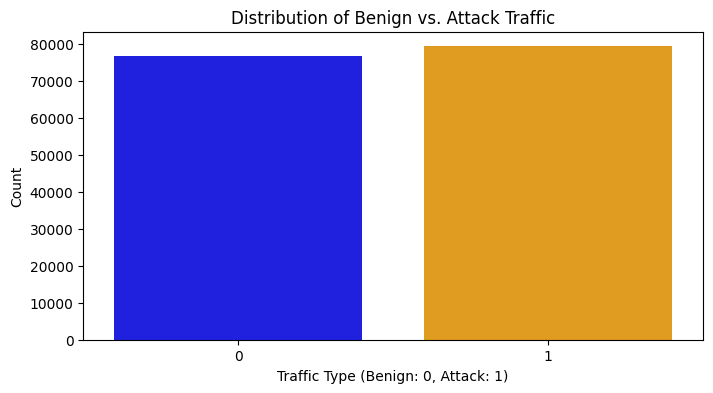

In [ ]:
plt.figure(figsize=(8, 4))
sns.countplot(x='label_encoded', data=train_df, palette=['blue', 'orange'])
plt.title('Distribution of Benign vs. Attack Traffic')
plt.xlabel('Traffic Type (Benign: 0, Attack: 1)')
plt.ylabel('Count')
plt.show()
# from google.colab import files
# # Assuming the plot is currently displayed, save it to a file
# plt.savefig("/content/drive/My Drive/ddos_images/my_plot.png")

##Correlation Matrix

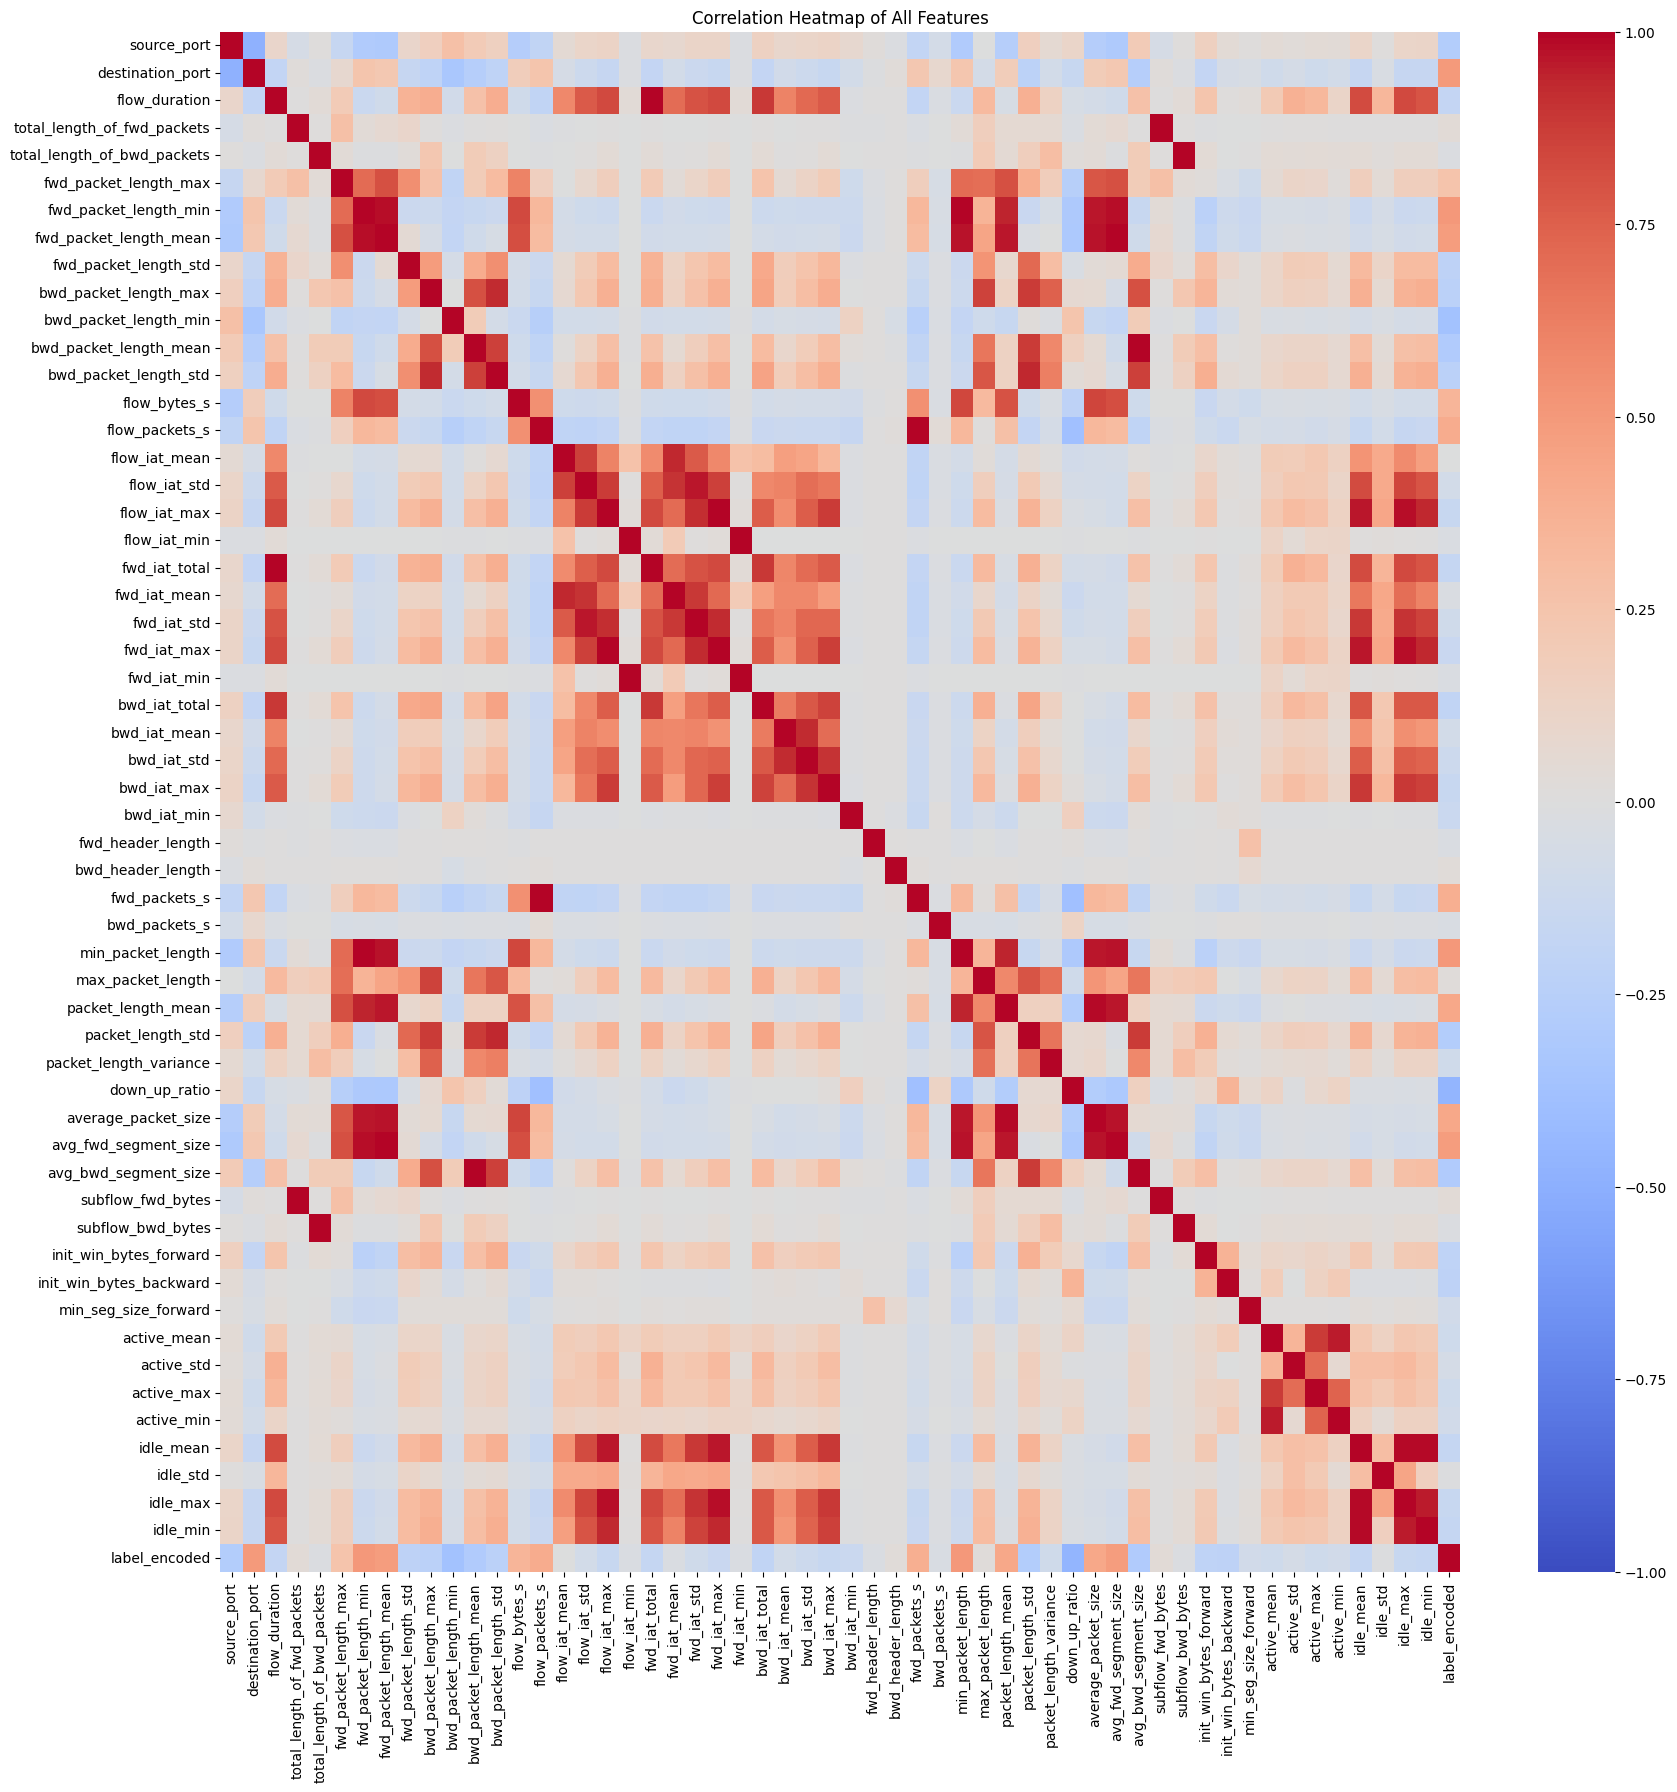

In [ ]:
numeric_df = train_df.select_dtypes(include=[float, int])

plt.figure(figsize=(20, 20))  # Adjust figure size based on the number of features
sns.heatmap(numeric_df.corr(), annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of All Features')
plt.show()

##Variance Inflation Factor

In [ ]:
# import pandas as pd
# import numpy as np
# from statsmodels.stats.outliers_influence import variance_inflation_factor

# # 1. Select numerical features
# X = train_df.select_dtypes(include=[np.number])

# # 2. Check for NaN values and handle them
# # Replace NaN with the mean of the column or any other strategy
# X = X.fillna(X.mean())

# # 3. Check for infinite values and handle them
# # Replace inf with a large finite number (or use X.replace([np.inf, -np.inf], np.nan).dropna())
# X = X.replace([np.inf, -np.inf], np.nan)
# X = X.fillna(X.mean())  # Fill NaNs created by replacing infs

# # 4. Calculating VIF for each feature
# vif_data = pd.DataFrame()
# vif_data["feature"] = X.columns
# vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

# # 5. Output the VIF data
# print(vif_data)

In [ ]:
# # Sort the VIF data by the VIF values in descending order
# vif_data_sorted = vif_data.sort_values(by='VIF', ascending=False)

# # Select the top 20 features with the highest VIF values
# top_20_vif = vif_data_sorted.head(20)

# # Output the top 20 VIF data
# print(top_20_vif)

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # Example of loading a reduced or selected subset of your data
# # Assuming vif_data is already a DataFrame with VIF calculations

# # Sorting VIF values for clear visualization
# vif_sorted = vif_data.sort_values(by='VIF', ascending=False)

# # Filtering features with VIF greater than 20
# high_vif = vif_sorted[vif_sorted['VIF'] > 20]  # Only include VIF values greater than 20

# # Plotting features with VIF greater than 20
# plt.figure(figsize=(12, 6))
# plt.bar(high_vif['feature'], high_vif['VIF'], color='skyblue')
# plt.axhline(y=20, color='r', linestyle='--', label='Threshold (VIF=20)')
# plt.xlabel('Features')
# plt.ylabel('VIF Value')
# plt.title('Features with VIF Greater Than 20')
# plt.xticks(rotation=45, ha='right')
# plt.legend()
# plt.tight_layout()
# plt.show()

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Replace Inf with a very large value and NaN with a defined value
# vif_sorted['VIF'] = vif_sorted['VIF'].replace([np.inf, -np.inf], np.nan)
# vif_sorted['VIF'].fillna(vif_sorted['VIF'].max(), inplace=True)  # Replace NaN with the max value or a set value

# # Apply log transformation safely
# vif_sorted['Log_VIF'] = np.log10(vif_sorted['VIF'].replace(0, np.nan))  # Avoid log of zero

# # Plotting the features with log-transformed VIF values
# plt.figure(figsize=(14, 8))
# plt.bar(vif_sorted['feature'], vif_sorted['Log_VIF'], color='skyblue', edgecolor='black')
# plt.axhline(y=np.log10(20), color='r', linestyle='--', label='Threshold (Log VIF=20)')

# # Set y-axis limits after ensuring no NaN or Inf values remain
# plt.ylim([0, vif_sorted['Log_VIF'].max() + 1])  # Adjust as needed

# plt.xlabel('Features')
# plt.ylabel('Log VIF Value')
# plt.title('Features by Log VIF Value')
# plt.xticks(rotation=45, ha='right')
# plt.legend()
# plt.tight_layout()
# plt.show()


In [ ]:
# # 5. Save the VIF data to a CSV file
# vif_data.to_csv('vif_data.csv', index=False)

# # Print a confirmation message
# print("VIF data has been saved to 'vif_data.csv'.")

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
metadata_cloumns = ["flow_id", "source_ip", "destination_ip","source_port","destination_port","timestamp"]

cleaned_train_df = train_df.drop(columns=metadata_cloumns)

def remove_infinite_values(df, numerical_columns):
  for col in numerical_columns:
    df = df[~df[col].isin([np.inf, -np.inf])]
  return df

numerical_columns = cleaned_train_df.select_dtypes(include=['number']).columns

cleaned_train_df = remove_infinite_values(cleaned_train_df, numerical_columns)

X = cleaned_train_df.drop('label_encoded', axis=1)
y = cleaned_train_df['label_encoded']



# Apply Lasso for feature selection
lasso = Lasso(alpha=0.01)  # Adjust alpha based on dataset scale
lasso.fit(X, y)

# Use SelectFromModel to select features
model = SelectFromModel(lasso, prefit=True)
X_selected = model.transform(X)

# Check the selected features
selected_features = X.columns[(model.get_support())]
print(f'Selected Features: {selected_features}')


Selected Features: Index(['protocol', 'total_fwd_packets', 'fwd_packet_length_max',
       'fwd_packet_length_min', 'fwd_packet_length_mean',
       'fwd_packet_length_std', 'bwd_packet_length_max',
       'bwd_packet_length_min', 'bwd_packet_length_std', 'min_packet_length',
       'packet_length_mean', 'packet_length_std', 'ack_flag_count',
       'urg_flag_count', 'average_packet_size', 'avg_fwd_segment_size',
       'avg_bwd_segment_size', 'subflow_fwd_packets', 'act_data_pkt_fwd'],
      dtype='object')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.412e+03, tolerance: 3.806e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


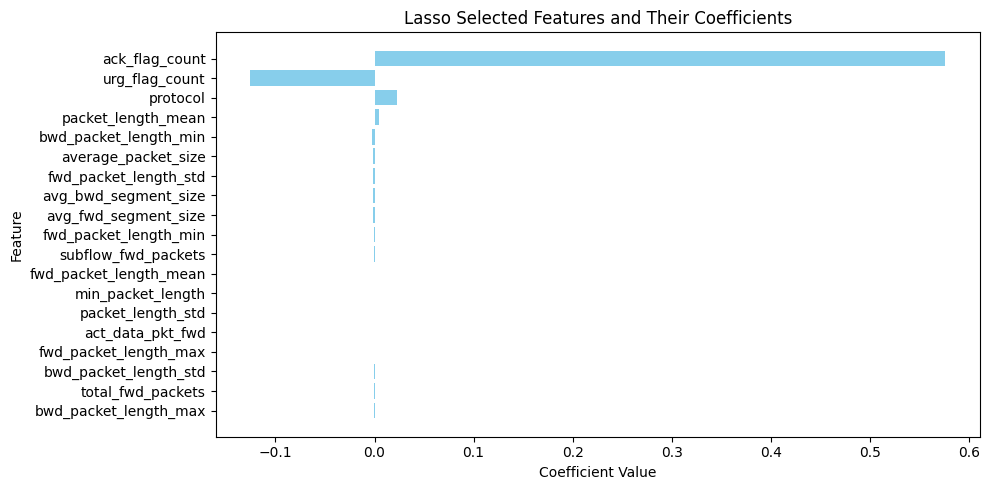

In [ ]:
# Extract coefficients of the selected features
lasso_coefficients = lasso.coef_[model.get_support()]

# Create a DataFrame for visualization
feature_importance = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': lasso_coefficients
})

# Sort by absolute value of coefficients for better visualization
feature_importance = feature_importance.reindex(feature_importance['Coefficient'].abs().sort_values(ascending=False).index)

# Plotting the feature importances
plt.figure(figsize=(10, 5))
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Lasso Selected Features and Their Coefficients')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.tight_layout()
plt.show()

## Features to Remove

In [ ]:
metadata_cloumns = ["flow_id", "source_ip", "destination_ip","source_port","destination_port","timestamp"]
train_df = train_df.drop(columns=metadata_cloumns)
test_df = test_df.drop(columns=metadata_cloumns)

In [ ]:
data = data.drop(columns=metadata_cloumns)

## Data Cleaning

In [ ]:

def check_data_before_cleaning(df, numerical_columns):
    # Select only numeric columns for checking
    numeric_df = df[numerical_columns]

    # Check for infinite values
    inf_values = (numeric_df == np.inf).sum().sum() + (numeric_df == -np.inf).sum().sum()
    print(f"Number of infinite values: {inf_values}")

    # Check for NaN values
    nan_counts = numeric_df.isna().sum().sort_values(ascending=False)
    print("NaN values per column (highest first):")
    print(nan_counts)

In [ ]:
def check_data_before_cleaning(df, numerical_columns):
    # Select only numeric columns for checking
    numeric_df = df[numerical_columns]

    # Check for infinite values
    inf_values = (numeric_df == np.inf).sum().sum() + (numeric_df == -np.inf).sum().sum()
    print(f"Number of infinite values: {inf_values}")

    # Check for NaN values
    nan_counts = numeric_df.isna().sum().sort_values(ascending=False)
    print("NaN values per column (highest first):")
    print(nan_counts)


In [ ]:
numerical_columns = train_df.select_dtypes(include=['number']).columns

In [ ]:
check_data_before_cleaning(train_df, numerical_columns)
check_data_before_cleaning(test_df, numerical_columns)

Number of infinite values: 7210
NaN values per column (highest first):
protocol                0
cwe_flag_count          0
fwd_avg_packets_bulk    0
fwd_avg_bytes_bulk      0
avg_bwd_segment_size    0
                       ..
bwd_iat_total           0
fwd_iat_min             0
fwd_iat_max             0
fwd_iat_std             0
label_encoded           0
Length: 78, dtype: int64
Number of infinite values: 3102
NaN values per column (highest first):
protocol                0
cwe_flag_count          0
fwd_avg_packets_bulk    0
fwd_avg_bytes_bulk      0
avg_bwd_segment_size    0
                       ..
bwd_iat_total           0
fwd_iat_min             0
fwd_iat_max             0
fwd_iat_std             0
label_encoded           0
Length: 78, dtype: int64


In [ ]:
def check_nan_values(df, numerical_columns):
  # Select only numeric columns for checking
  numeric_df = df[numerical_columns]

  # Check for NaN values
  nan_counts = numeric_df.isna().sum().sort_values(ascending=False)
  print("NaN values per column (highest first):")
  print(nan_counts)

In [ ]:
check_nan_values(train_df, numerical_columns)
check_nan_values(test_df, numerical_columns)

NaN values per column (highest first):
protocol                0
cwe_flag_count          0
fwd_avg_packets_bulk    0
fwd_avg_bytes_bulk      0
avg_bwd_segment_size    0
                       ..
bwd_iat_total           0
fwd_iat_min             0
fwd_iat_max             0
fwd_iat_std             0
label_encoded           0
Length: 78, dtype: int64
NaN values per column (highest first):
protocol                0
cwe_flag_count          0
fwd_avg_packets_bulk    0
fwd_avg_bytes_bulk      0
avg_bwd_segment_size    0
                       ..
bwd_iat_total           0
fwd_iat_min             0
fwd_iat_max             0
fwd_iat_std             0
label_encoded           0
Length: 78, dtype: int64


In [ ]:
def remove_infinite_values(df, numerical_columns):
  for col in numerical_columns:
    df = df[~df[col].isin([np.inf, -np.inf])]
  return df

In [ ]:
train_df = remove_infinite_values(train_df, numerical_columns)
test_df = remove_infinite_values(test_df, numerical_columns)

In [ ]:
train_df.shape

(152230, 78)

In [ ]:
# X = data.drop('label_encoded', axis=1)
# y = data['label_encoded']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# *Preparing* Training and Testing Data

In [ ]:
X_train = train_df.drop('label_encoded', axis=1)
y_train = train_df['label_encoded']
X_test = test_df.drop('label_encoded', axis=1)
y_test = test_df['label_encoded']

In [ ]:
X_train.shape

(152230, 77)

In [ ]:
X_test.shape

(65250, 77)

# Model Training and Evaluation for DDoS Detection

## Training Without Metadata

In [ ]:
train_df.shape

(152230, 78)

In [ ]:
from sklearn.linear_model import SGDClassifier, PassiveAggressiveClassifier, Perceptron
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
import numpy as np

# Initialize the scalers
scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'Normalizer': Normalizer()
}


def evaluate_model(model, X_test, y_test):
    """Evaluates the model on the test set and returns performance metrics."""
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Use predict_proba for ROC AUC in multiclass classification
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)
        if y_prob.shape[1] == 2:
            roc_auc = roc_auc_score(y_test, y_prob[:, 1])  # Use probabilities for the positive class
        else:
            roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr', average='weighted')  # For multiclass
    else:
        roc_auc = None  # Some models like Perceptron do not have predict_proba

    return accuracy, precision, recall, f1, roc_auc

def scale_data(scaler, X_train, X_test, X_initial):
    """Scales the data using the given scaler and returns scaled datasets."""
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_initial_scaled = scaler.transform(X_initial)
    return X_train_scaled, X_test_scaled, X_initial_scaled

def incremental_training(model, X_train_scaled, y_train, X_test_scaled, y_test, initial_batch_size, batch_size):
    """Performs incremental training on the model and evaluates performance over time."""
    classes = np.unique(y_train[:initial_batch_size])
    model.partial_fit(X_train_scaled[:initial_batch_size], y_train[:initial_batch_size], classes=classes)

    # Initial evaluation
    initial_metrics = evaluate_model(model, X_test_scaled, y_test)
    print("\nInitial Model Evaluation:")
    print("Accuracy:", initial_metrics[0])
    print("Precision:", initial_metrics[1])
    print("Recall:", initial_metrics[2])
    print("F1 Score:", initial_metrics[3])
    print("ROC AUC:", initial_metrics[4])

    # Incremental learning loop
    metrics_over_time = []
    for i in range(initial_batch_size, len(X_train_scaled), batch_size):
        X_batch, y_batch = X_train_scaled[i: i + batch_size], y_train[i: i + batch_size]
        model.partial_fit(X_batch, y_batch, classes=classes)

        # Evaluate the model at each step
        metrics = evaluate_model(model, X_test_scaled, y_test)
        metrics_over_time.append(metrics)
        print(f"\nMetrics after batch {len(metrics_over_time)}:")
        print("Accuracy:", metrics[0])
        print("Precision:", metrics[1])
        print("Recall:", metrics[2])
        print("F1 Score:", metrics[3])
        print("ROC AUC:", metrics[4])

    metrics_over_time = np.array(metrics_over_time)
    return metrics_over_time

In [ ]:
# Function to plot metrics with dynamic titles
def plot_metrics(metrics_over_time, model_name, scaler_name):
    """Plots the performance metrics over time."""
    plt.figure(figsize=(14, 8))

    # Extract metrics for plotting
    batches = range(1, len(metrics_over_time) + 1)
    accuracy = metrics_over_time[:, 0]
    precision = metrics_over_time[:, 1]
    recall = metrics_over_time[:, 2]
    f1 = metrics_over_time[:, 3]

    # Check if ROC AUC is available (assuming it's the 5th column if present)
    roc_auc_available = metrics_over_time.shape[1] > 4
    if roc_auc_available:
        roc_auc = metrics_over_time[:, 4]

    # Plot each metric
    plt.plot(batches, accuracy, label='Accuracy', marker='o')
    plt.plot(batches, precision, label='Precision', marker='o')
    plt.plot(batches, recall, label='Recall', marker='o')
    plt.plot(batches, f1, label='F1 Score', marker='o')

    if roc_auc_available:
        plt.plot(batches, roc_auc, label='ROC AUC', marker='o')

    # Customize the plot
    plt.title(f'{model_name} Performance with {scaler_name} Scaling Over Incremental Batches')
    plt.xlabel('Batch Number')
    plt.ylabel('Performance Metrics')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
batch_size = 5000

# Initialize models
sgd_params = {
    'alpha': 0.0001,
    'learning_rate': 'optimal',
    'penalty': 'l2',
    'max_iter': 1000
}

In [ ]:
sgd_model = SGDClassifier(loss='log_loss', random_state=42, **sgd_params)
pa_model = PassiveAggressiveClassifier(random_state=42, max_iter=1000, tol=1e-3)
perceptron_model = Perceptron(max_iter=1000, tol=1e-3)

X_train = train_df.drop('label_encoded', axis=1)
y_train = train_df['label_encoded']
X_test = test_df.drop('label_encoded', axis=1)
y_test = test_df['label_encoded']
# Split the data into initial and incremental parts
initial_batch_size = int(0.2 * len(X_train))
X_initial, y_initial = X_train[:initial_batch_size], y_train[:initial_batch_size]
# Check shapes before training
print("Initial training data shape:", X_initial.shape)
print("Test data shape:", X_test.shape)

Initial training data shape: (30446, 77)
Test data shape: (65250, 77)


In [ ]:
print("After Removing Metadata")

metrics_storage = {}

for scaler_name, scaler in scalers.items():
    print(f"\nUsing {scaler_name}:")

    # Scale data
    X_train_scaled, X_test_scaled, X_initial_scaled = scale_data(scaler, X_train, X_test, X_initial)

    # Dictionary to store metrics for each model for the current scaler
    model_metrics = {}

    # Incremental training and evaluation for SGDClassifier
    print("\nTraining SGDClassifier:")
    sgd_metrics = incremental_training(sgd_model, X_train_scaled, y_train, X_test_scaled, y_test, initial_batch_size, batch_size)
    model_metrics['SGDClassifier'] = sgd_metrics

    # Incremental training and evaluation for PassiveAggressiveClassifier
    print("\nTraining PassiveAggressiveClassifier:")
    pa_metrics = incremental_training(pa_model, X_train_scaled, y_train, X_test_scaled, y_test, initial_batch_size, batch_size)
    model_metrics['PassiveAggressiveClassifier'] = pa_metrics

    # Incremental training and evaluation for Perceptron
    print("\nTraining Perceptron:")
    perceptron_metrics = incremental_training(perceptron_model, X_train_scaled, y_train, X_test_scaled, y_test, initial_batch_size, batch_size)
    model_metrics['Perceptron'] = perceptron_metrics

    # Store metrics for the current scaler
    metrics_storage[scaler_name] = model_metrics

After Removing Metadata

Using StandardScaler:

Training SGDClassifier:

Initial Model Evaluation:
Accuracy: 0.6803831417624521
Precision: 0.7996830634393954
Recall: 0.6803831417624521
F1 Score: 0.6459293236573774
ROC AUC: 0.8803363207143537

Metrics after batch 1:
Accuracy: 0.6807509578544061
Precision: 0.8008225119161404
Recall: 0.6807509578544061
F1 Score: 0.6462319782697913
ROC AUC: 0.917037311205948

Metrics after batch 2:
Accuracy: 0.6803984674329502
Precision: 0.8017992954336556
Recall: 0.6803984674329502
F1 Score: 0.6455366750916304
ROC AUC: 0.8996177739507126

Metrics after batch 3:
Accuracy: 0.7309272030651341
Precision: 0.8225477492130766
Recall: 0.7309272030651341
F1 Score: 0.7109264293016886
ROC AUC: 0.9905404312789401

Metrics after batch 4:
Accuracy: 0.9293946360153257
Precision: 0.9375966896409247
Recall: 0.9293946360153257
F1 Score: 0.929091799938287
ROC AUC: 0.9958280689177176

Metrics after batch 5:
Accuracy: 0.8973486590038314
Precision: 0.914301410094196
Recall: 0.

### Evaluation Matrix for Without Metadata

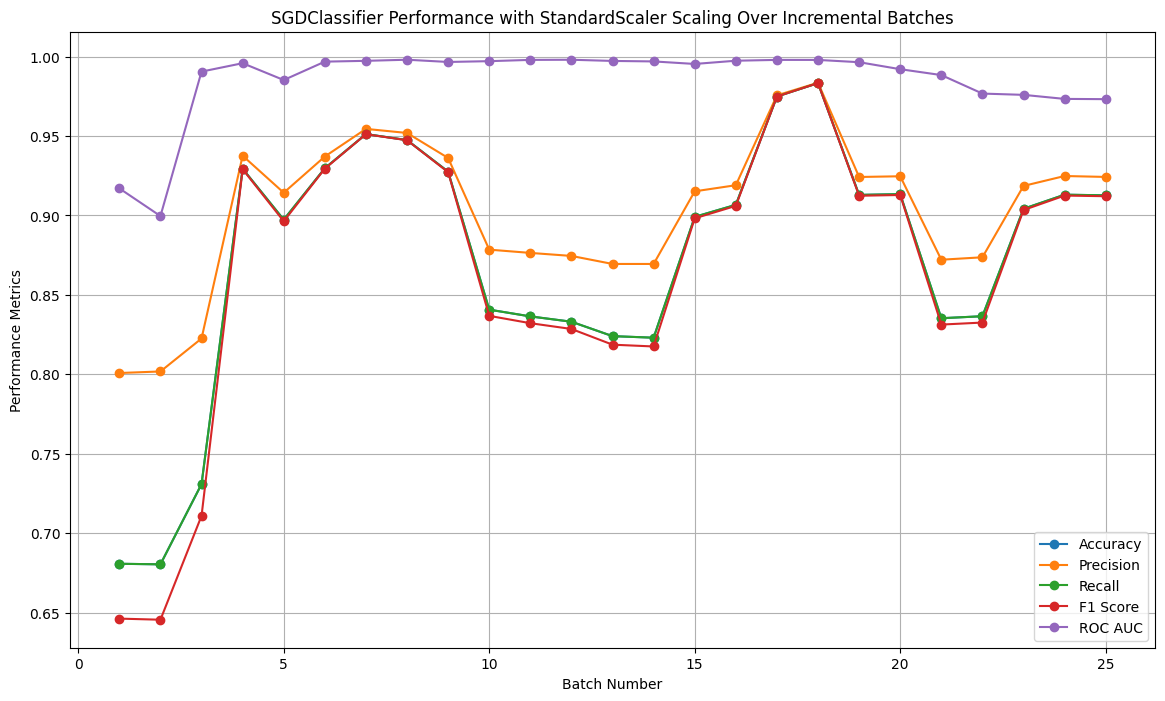

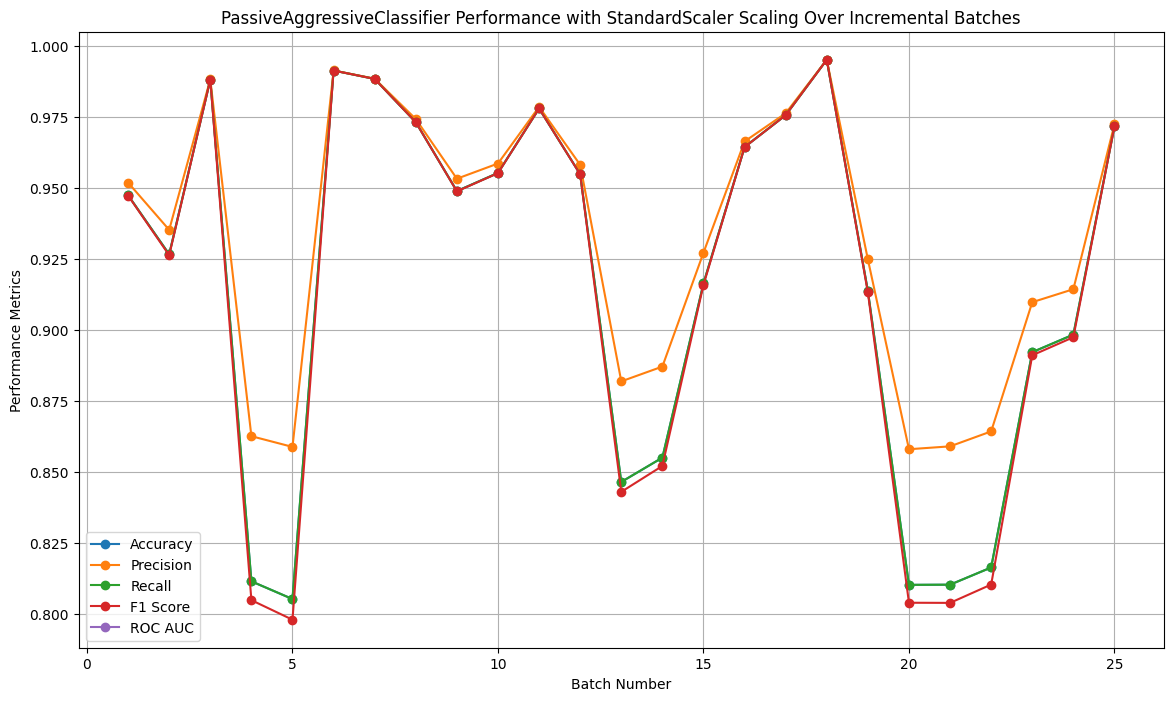

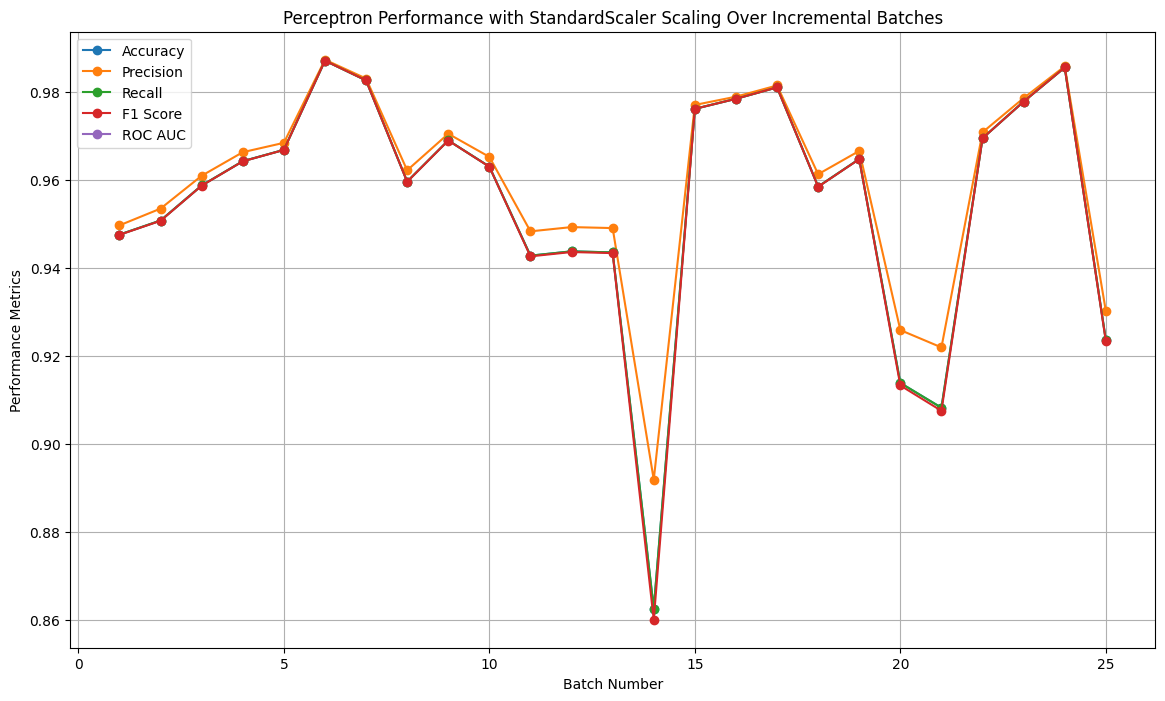

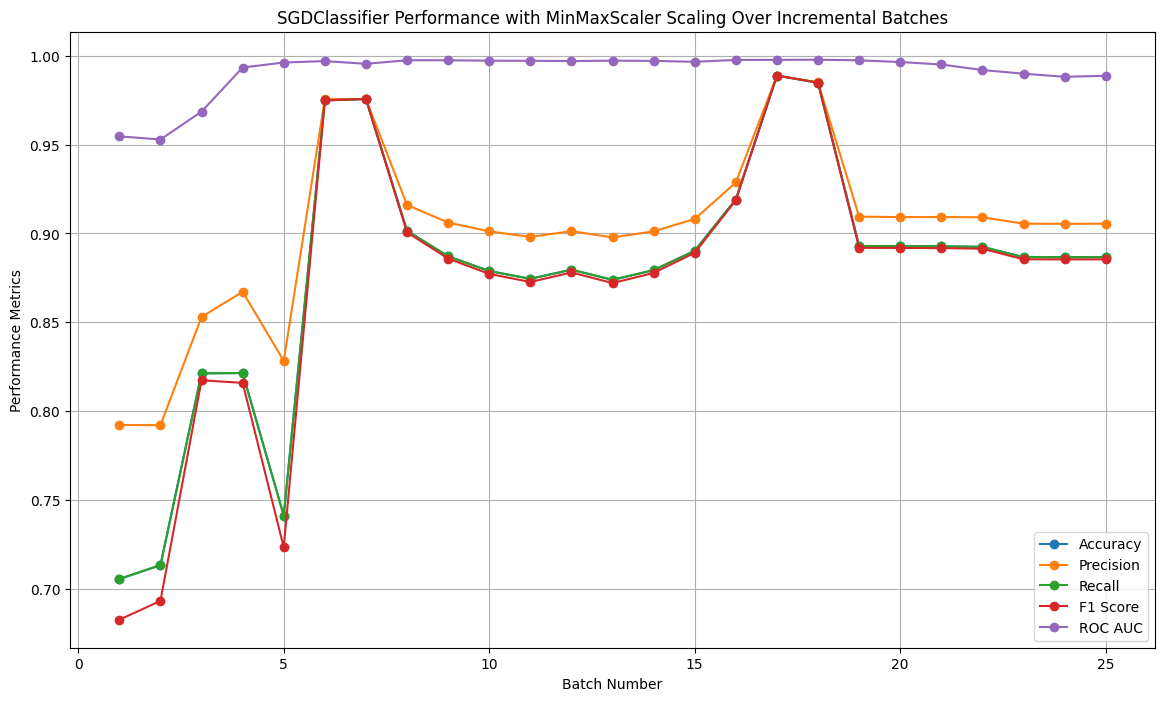

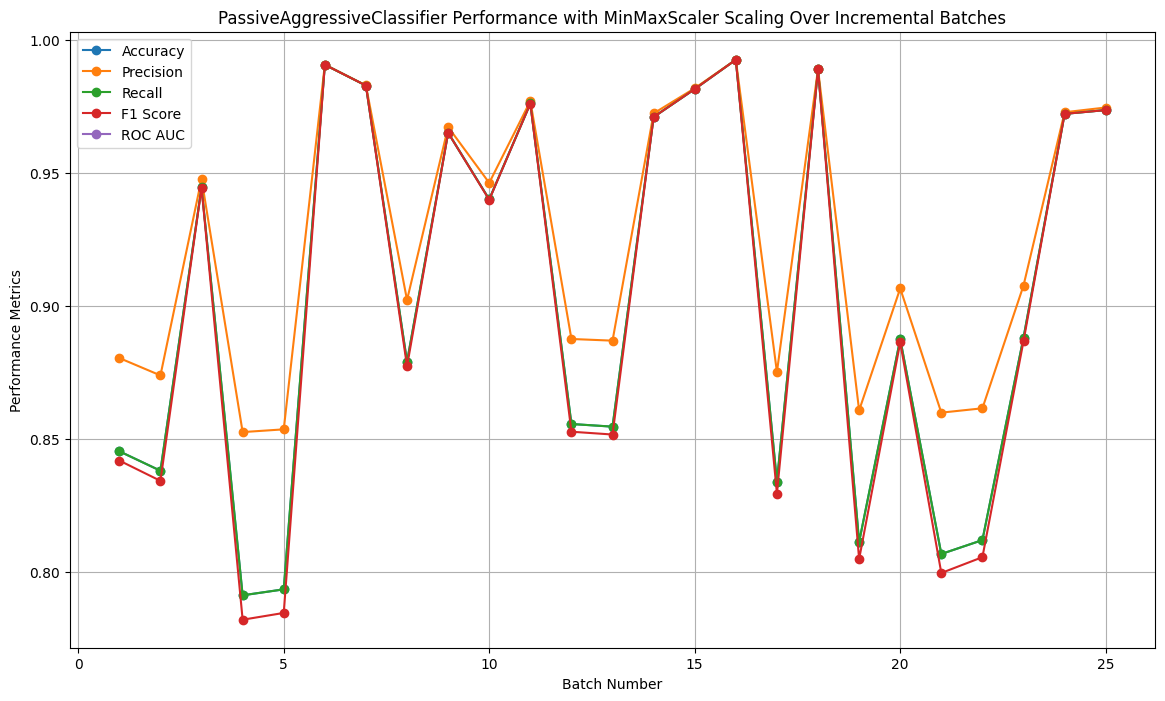

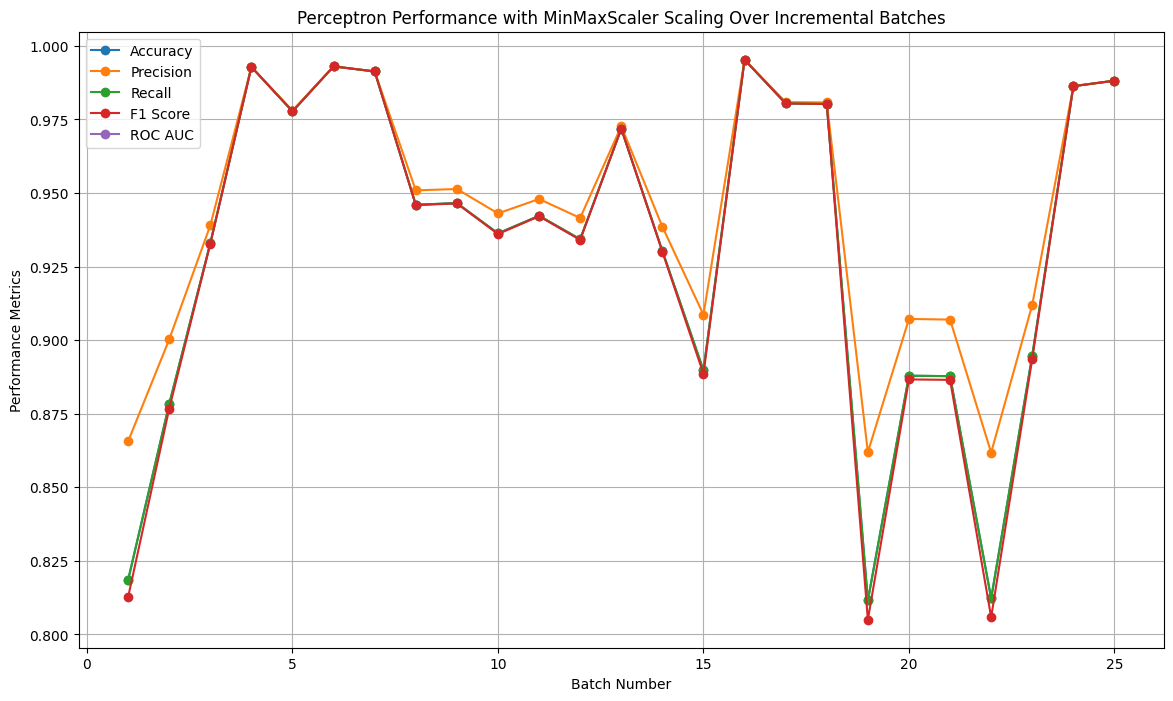

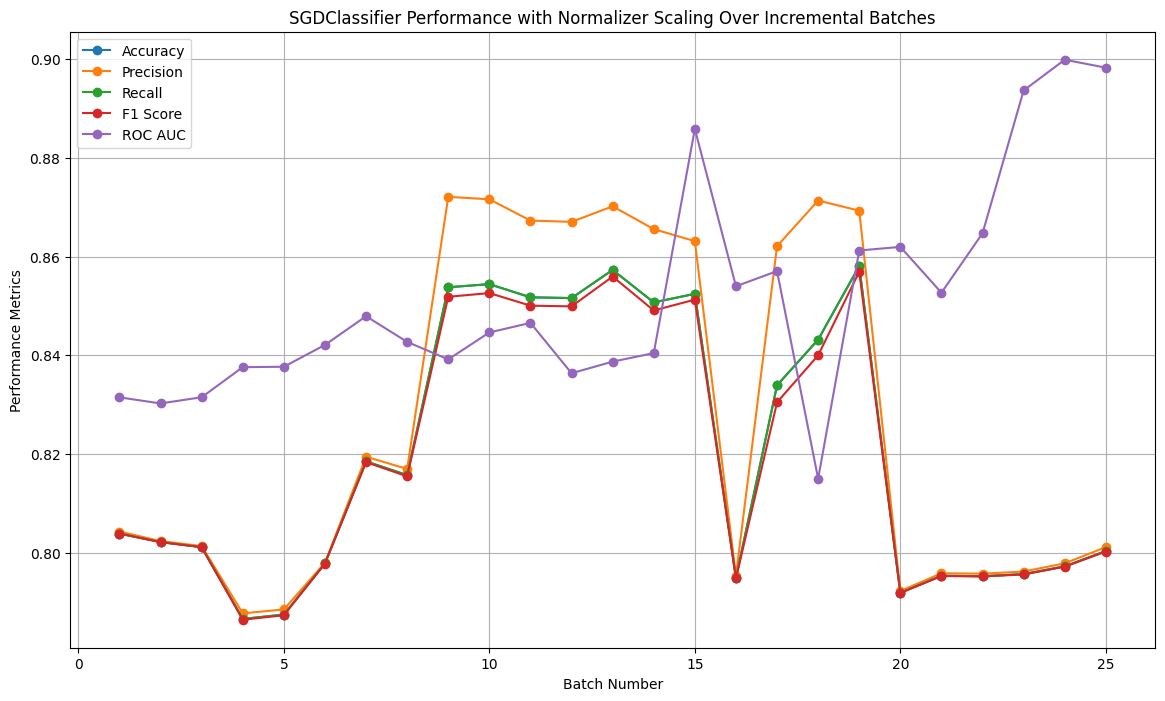

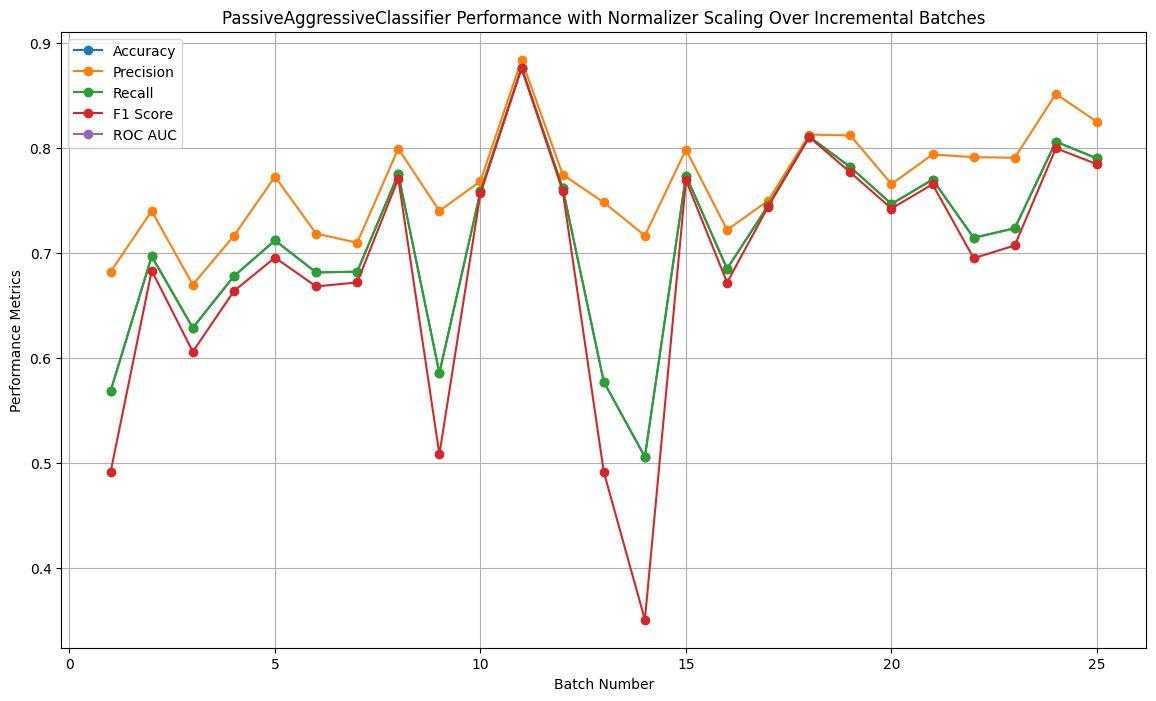

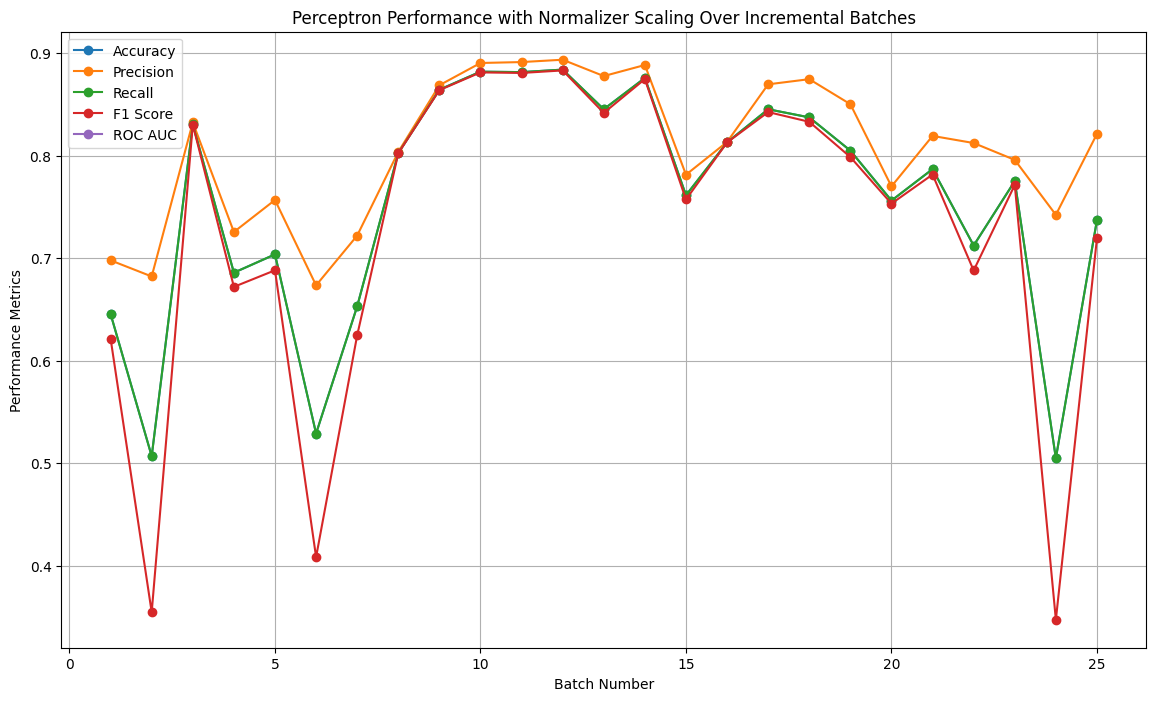

In [ ]:
# Plot all metrics after all scalers and models have been processed
for scaler_name, model_metrics in metrics_storage.items():
    for model_name, metrics in model_metrics.items():
        plot_metrics(metrics, model_name, scaler_name)

## Training Without Metadata and Correlated Features

In [ ]:
# List of features with null correlations to remove
features_to_remove = ['bwd_psh_flags', 'fwd_urg_flags', 'bwd_urg_flags',
                      'fwd_avg_bytes_bulk', 'fwd_avg_packets_bulk',
                      'fwd_avg_bulk_rate', 'bwd_avg_bytes_bulk',
                      'bwd_avg_packets_bulk', 'bwd_avg_bulk_rate']

clean_train_df = train_df.drop(columns=features_to_remove)
clean_test_df = test_df.drop(columns=features_to_remove)
# Remove the specified features
clean_data = data.drop(columns=features_to_remove)

# Verify the features have been removed
train_df.head()

protocol  flow_duration  total_fwd_packets  total_backward_packets  \
0         6              2                  3                       0   
1        17          20754                  2                       2   
2         6             70                  2                       2   
3         6              3                  2                       0   
4         6              1                  2                       0   

   total_length_of_fwd_packets  total_length_of_bwd_packets  \
0                       1125.0                          0.0   
1                         56.0                        184.0   
2                         12.0                         12.0   
3                          0.0                          0.0   
4                         12.0                          0.0   

   fwd_packet_length_max  fwd_packet_length_min  fwd_packet_length_mean  \
0                 1094.0                    0.0                   375.0   
1                   28.0                   28.0                    28.0   
2                    6.0                    6.0                     6.0   
3                    0.0                    0.0                     0.0   
4                    6.0                    6.0                     6.0   

   fwd_packet_length_std  ...  min_seg_size_forward  active_mean  active_std  \
0             622.865173  ...                    32          0.0         0.0   
1               0.000000  ...                    32          0.0         0.0   
2               0.000000  ...                    20          0.0         0.0   
3               0.000000  ...                    32          0.0         0.0   
4               0.000000  ...                    20          0.0         0.0   

   active_max  active_min  idle_mean  idle_std  idle_max  idle_min  \
0         0.0         0.0        0.0       0.0       0.0       0.0   
1         0.0         0.0        0.0       0.0       0.0       0.0   
2         0.0         0.0        0.0       0.0       0.0       0.0   
3         0.0         0.0        0.0       0.0       0.0       0.0   
4         0.0         0.0        0.0       0.0       0.0       0.0   

   label_encoded  
0              0  
1              0  
2              1  
3              0  
4              1  

[5 rows x 78 columns]

In [ ]:
train_df.shape

(152230, 78)

In [ ]:
X_train = clean_train_df.drop('label_encoded', axis=1)
y_train = clean_train_df['label_encoded']
X_test = clean_test_df.drop('label_encoded', axis=1)
y_test = clean_test_df['label_encoded']

sgd_model = SGDClassifier(loss='log_loss', random_state=42, **sgd_params)
pa_model = PassiveAggressiveClassifier(random_state=42, max_iter=1000, tol=1e-3)
perceptron_model = Perceptron(max_iter=1000, tol=1e-3)

# Split the data into initial and incremental parts
initial_batch_size = int(0.2 * len(X_train))
X_initial, y_initial = X_train[:initial_batch_size], y_train[:initial_batch_size]
# Check shapes before training
print("Initial training data shape:", X_initial.shape)
print("Test data shape:", X_test.shape)

Initial training data shape: (30446, 68)
Test data shape: (65250, 68)


In [ ]:
metrics_storage = {}

# Loop through different scalers and models
print("After Removing Metadata + Highly Correlated Feature")
for scaler_name, scaler in scalers.items():
    print(f"\nUsing {scaler_name}:")

    # Scale data
    X_train_scaled, X_test_scaled, X_initial_scaled = scale_data(scaler, X_train, X_test, X_initial)

    # Dictionary to store metrics for each model for the current scaler
    model_metrics = {}

    # Incremental training and evaluation for SGDClassifier
    print("\nTraining SGDClassifier:")
    sgd_metrics = incremental_training(sgd_model, X_train_scaled, y_train, X_test_scaled, y_test, initial_batch_size, batch_size)
    model_metrics['SGDClassifier'] = sgd_metrics

    # Incremental training and evaluation for PassiveAggressiveClassifier
    print("\nTraining PassiveAggressiveClassifier:")
    pa_metrics = incremental_training(pa_model, X_train_scaled, y_train, X_test_scaled, y_test, initial_batch_size, batch_size)
    model_metrics['PassiveAggressiveClassifier'] = pa_metrics

    # Incremental training and evaluation for Perceptron
    print("\nTraining Perceptron:")
    perceptron_metrics = incremental_training(perceptron_model, X_train_scaled, y_train, X_test_scaled, y_test, initial_batch_size, batch_size)
    model_metrics['Perceptron'] = perceptron_metrics

    # Store metrics for the current scaler
    metrics_storage[scaler_name] = model_metrics

After Removing Metadata + Highly Correlated Feature

Using StandardScaler:

Training SGDClassifier:

Initial Model Evaluation:
Accuracy: 0.6803831417624521
Precision: 0.7996830634393954
Recall: 0.6803831417624521
F1 Score: 0.6459293236573774
ROC AUC: 0.8803363207143537

Metrics after batch 1:
Accuracy: 0.6807509578544061
Precision: 0.8008225119161404
Recall: 0.6807509578544061
F1 Score: 0.6462319782697913
ROC AUC: 0.917037311205948

Metrics after batch 2:
Accuracy: 0.6803984674329502
Precision: 0.8017992954336556
Recall: 0.6803984674329502
F1 Score: 0.6455366750916304
ROC AUC: 0.8996177739507126

Metrics after batch 3:
Accuracy: 0.7309272030651341
Precision: 0.8225477492130766
Recall: 0.7309272030651341
F1 Score: 0.7109264293016886
ROC AUC: 0.9905404312789401

Metrics after batch 4:
Accuracy: 0.9293946360153257
Precision: 0.9375966896409247
Recall: 0.9293946360153257
F1 Score: 0.929091799938287
ROC AUC: 0.9958280689177176

Metrics after batch 5:
Accuracy: 0.8973486590038314
Precision: 

### Evaluation Matrix for Without Metadata and Correlated Features

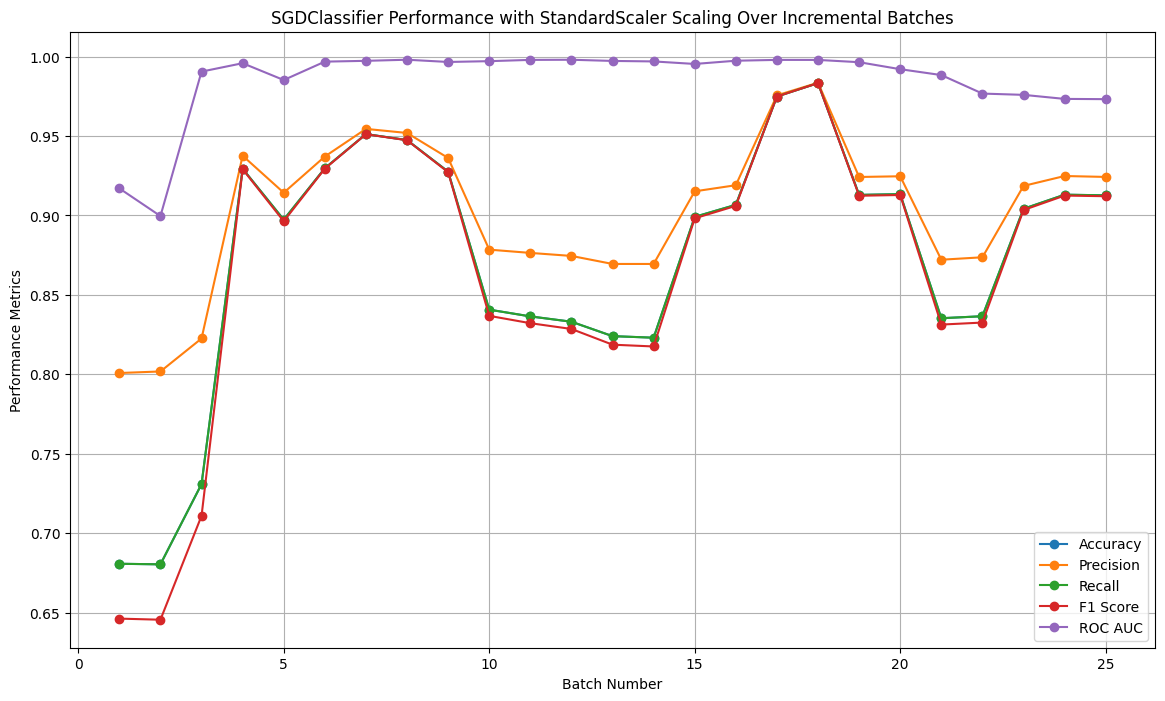

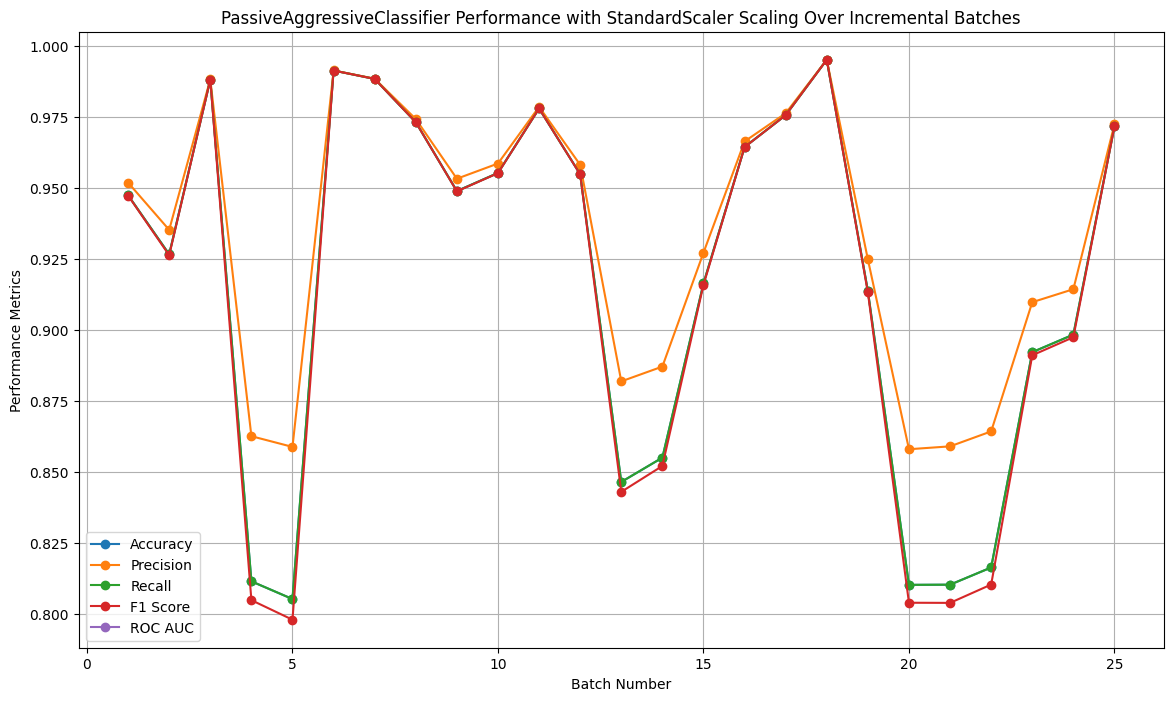

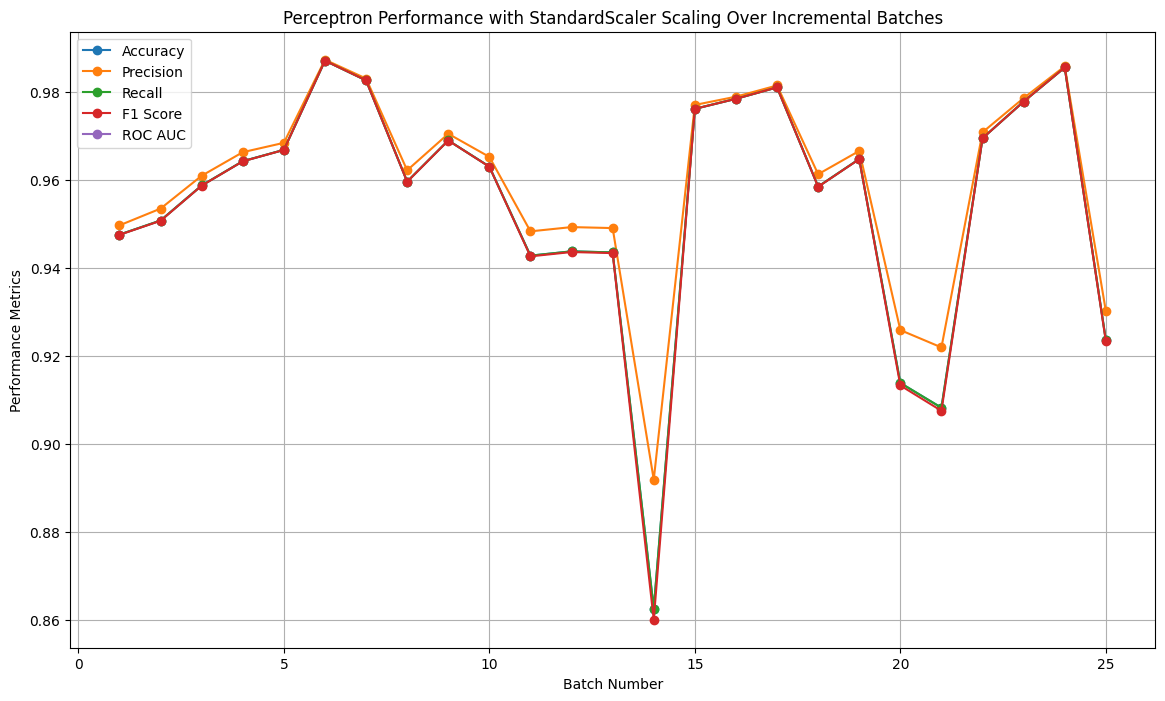

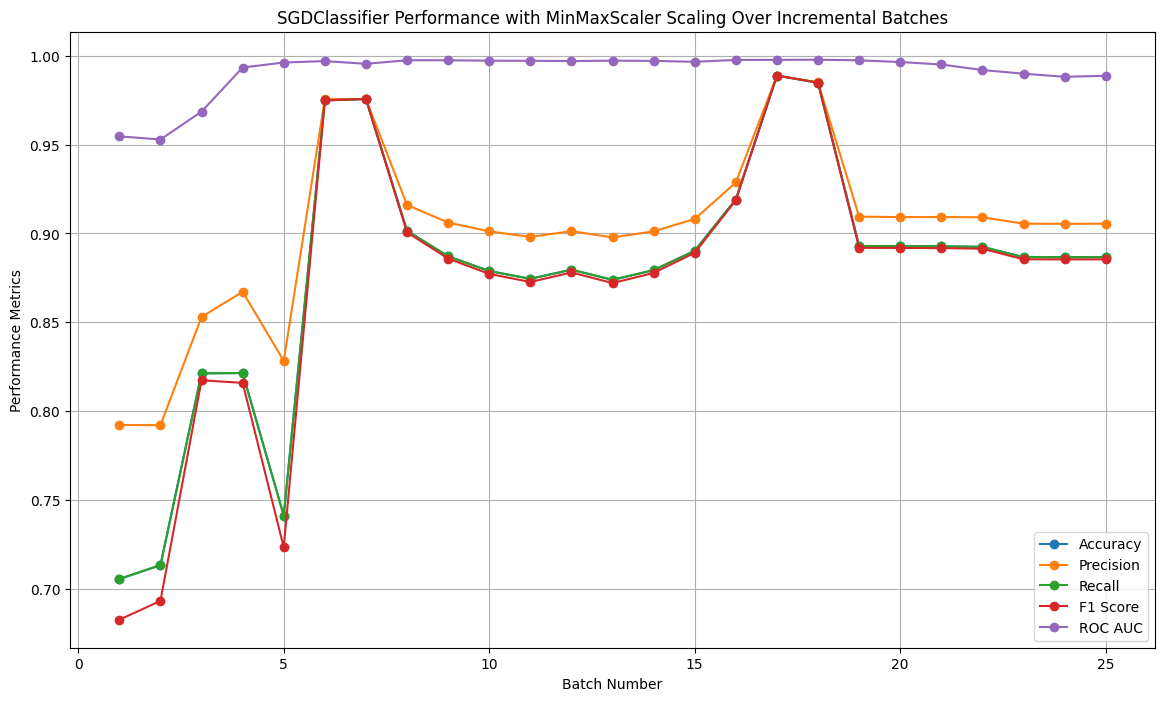

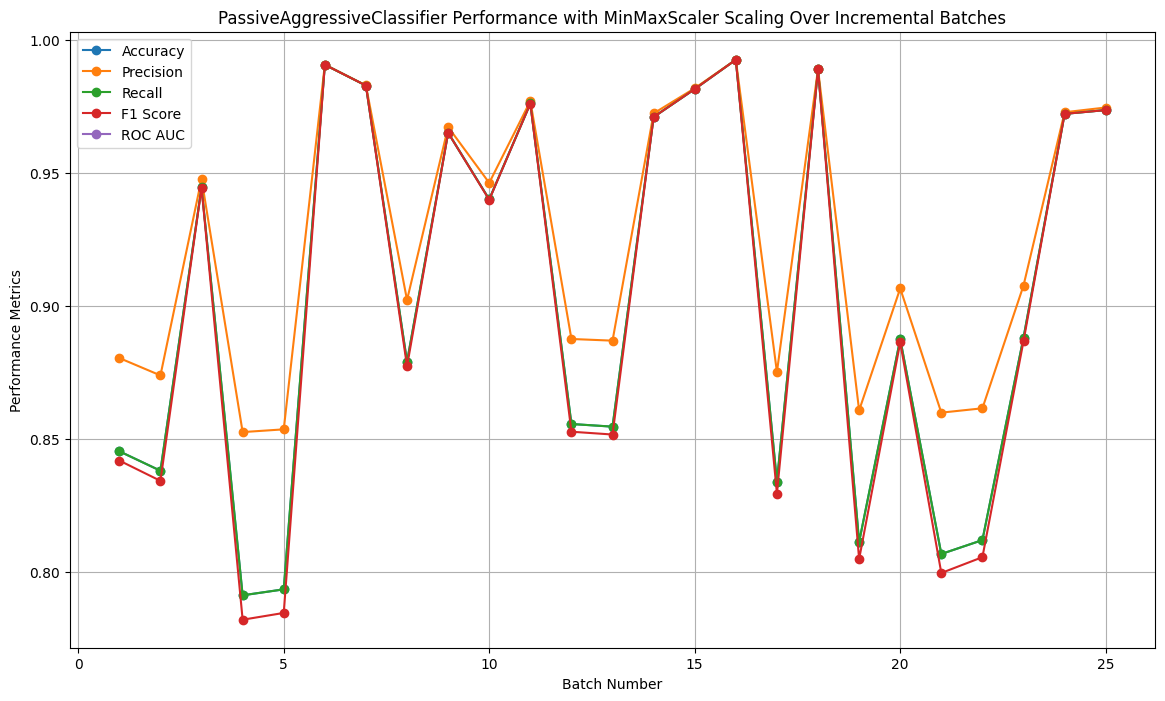

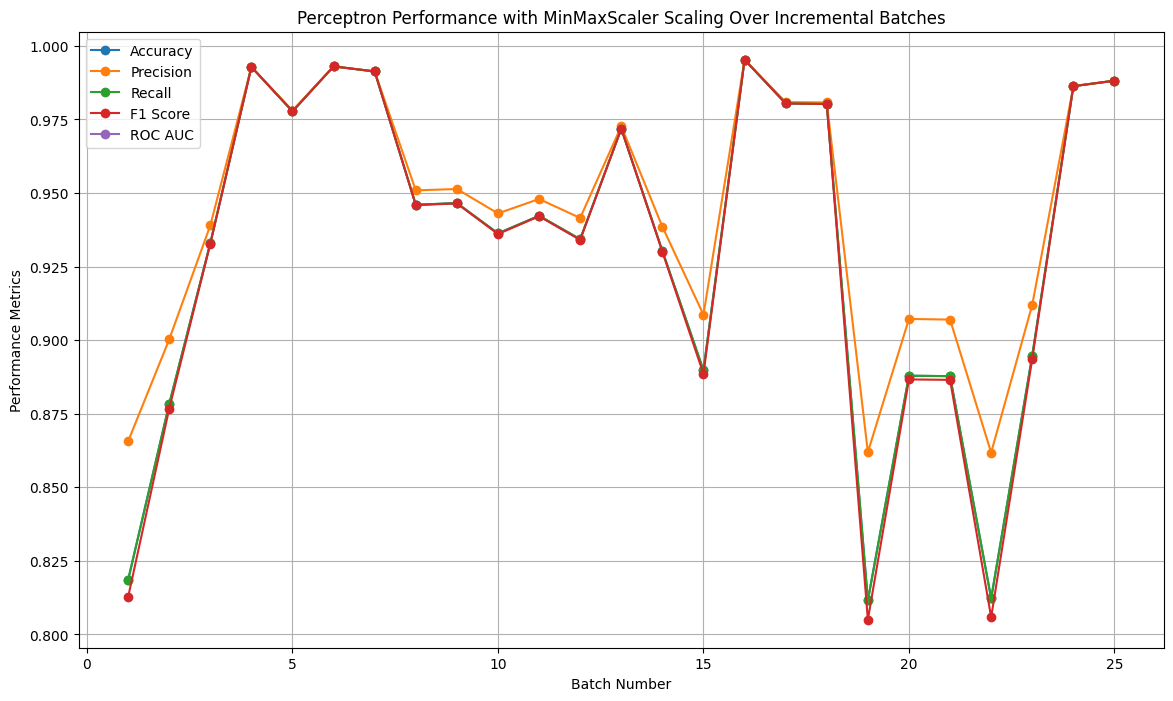

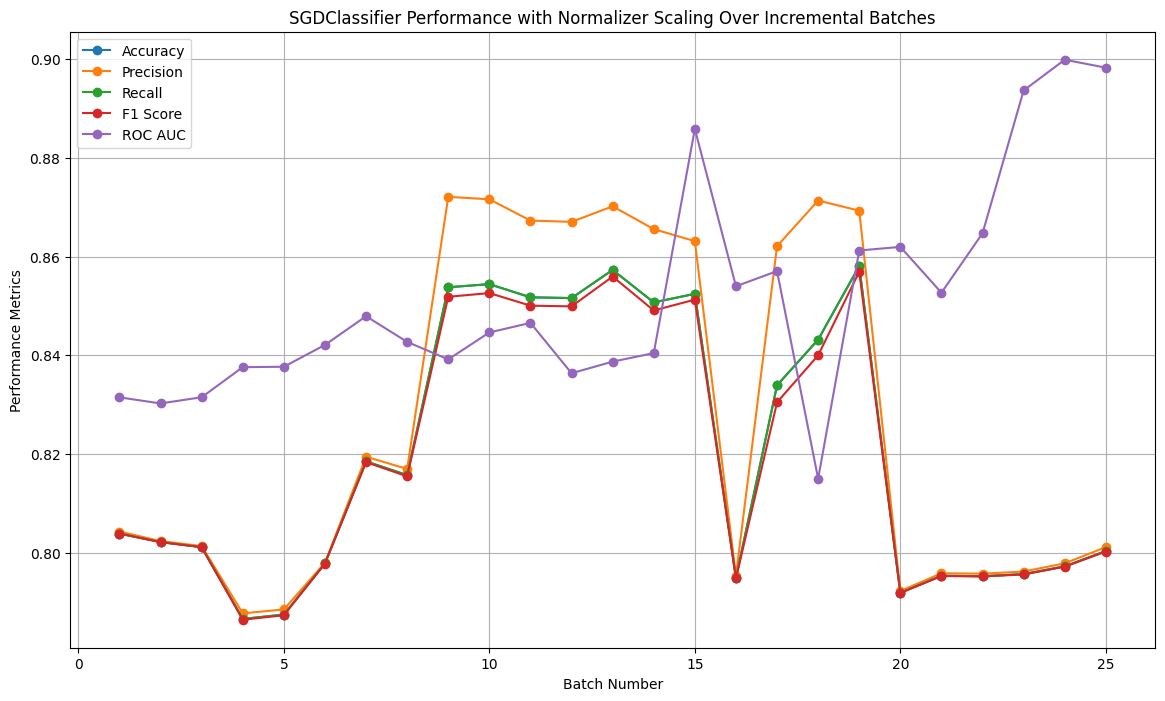

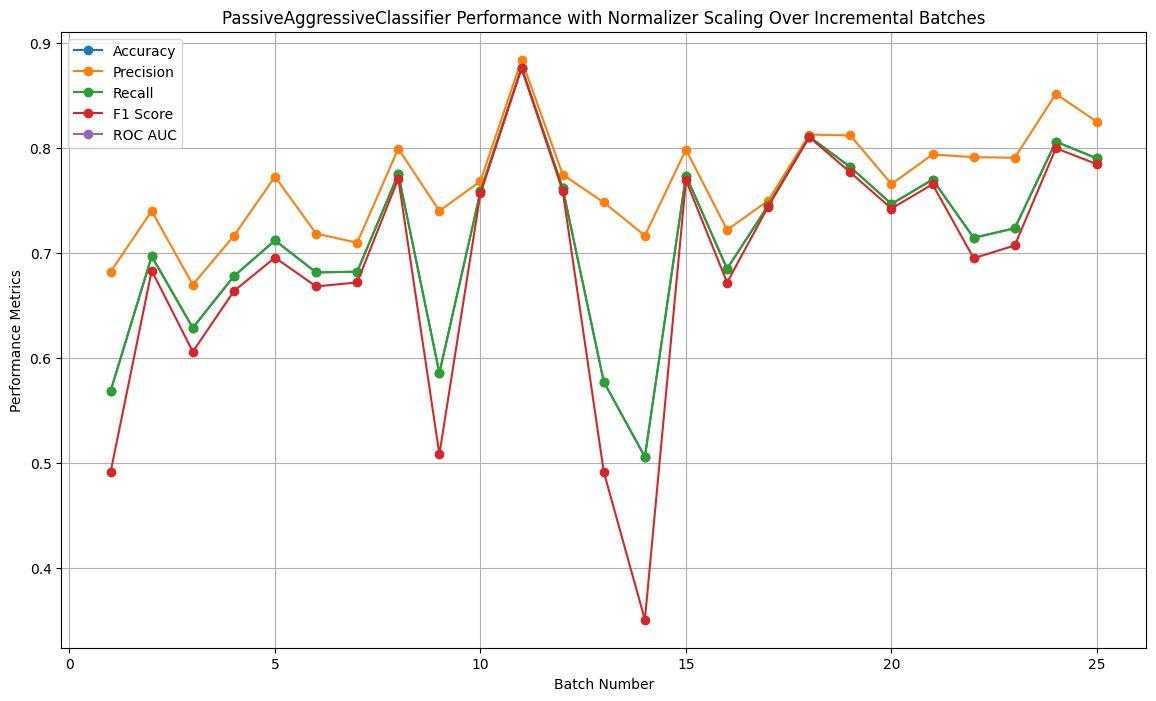

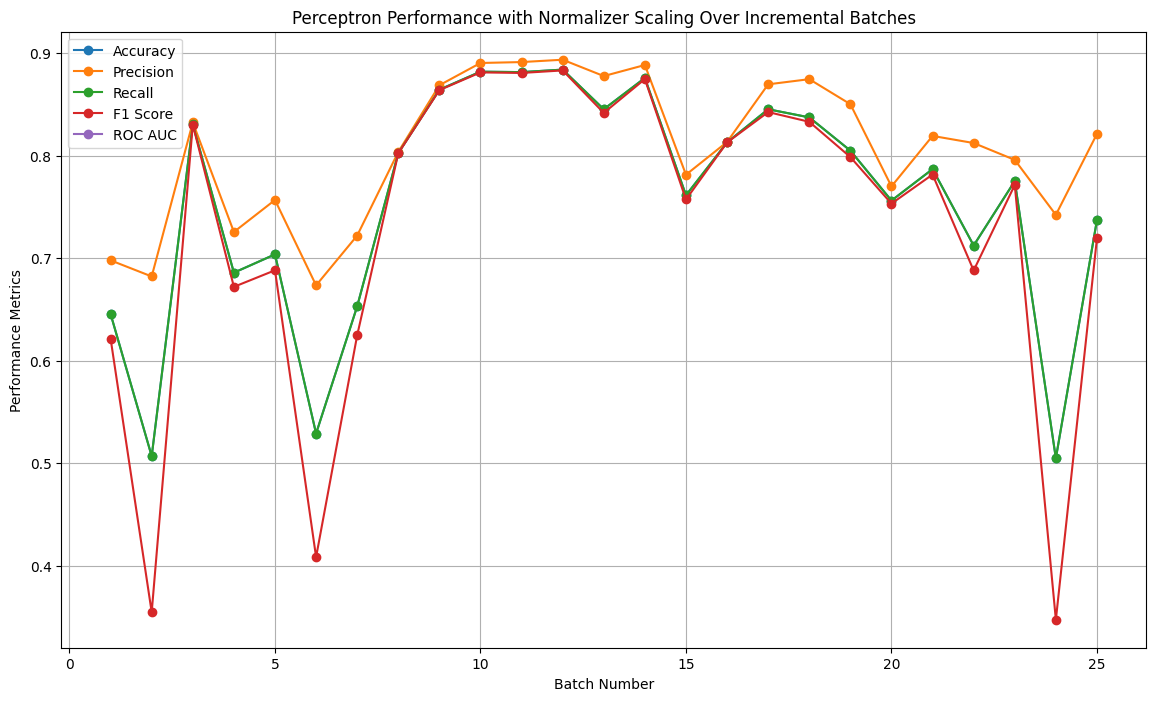

In [ ]:
# Plot all metrics after all scalers and models have been processed
for scaler_name, model_metrics in metrics_storage.items():
    for model_name, metrics in model_metrics.items():
        plot_metrics(metrics, model_name, scaler_name)

In [ ]:
sgd_model = SGDClassifier(loss='log_loss', random_state=42, **sgd_params)
pa_model = PassiveAggressiveClassifier(random_state=42, max_iter=1000, tol=1e-3)
perceptron_model = Perceptron(max_iter=1000, tol=1e-3)

X_train = train_df.drop('label_encoded', axis=1)
y_train = train_df['label_encoded']
X_test = test_df.drop('label_encoded', axis=1)
y_test = test_df['label_encoded']
# Split the data into initial and incremental parts
pca = PCA(n_components=0.95)  # Keep 95% of variance
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

initial_batch_size = int(0.2 * len(X_train))
X_initial, y_initial = X_train_pca[:initial_batch_size], y_train[:initial_batch_size]
# Check shapes before training
print("Initial training data shape:", X_initial.shape)
print("Test data shape:", X_test.shape)

Initial training data shape: (30446, 2)
Test data shape: (65250, 77)


## Training After Removing Metadata and Log Transformation

In [ ]:
def apply_transformations(df, target_column='label_encoded'):
    # Apply transformations to numerical features only
    for column in df.columns:
        if df[column].dtype in [np.float64, np.int64] and column != target_column:
            df[column] = np.log1p(df[column])  # Example transformation
    return df

In [ ]:
X_train = train_df.drop('label_encoded', axis=1)
y_train = train_df['label_encoded']
X_test = test_df.drop('label_encoded', axis=1)
y_test = test_df['label_encoded']

In [ ]:
# Apply transformations if necessary
X_train_transform = apply_transformations(X_train)
X_test_transform = apply_transformations(X_test)

# Drop rows with missing values in X and adjust y accordingly
X_train = X_train_transform.dropna()
y_train = y_train[X_train.index]  # Adjust y_train to match the new indices of X_train_transform

X_test = X_test_transform.dropna()
y_test = y_test[X_test.index]     # Adjust y_test to match the new indices of X_test_transform


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:

sgd_model = SGDClassifier(loss='log_loss', random_state=42, **sgd_params)
pa_model = PassiveAggressiveClassifier(random_state=42, max_iter=1000, tol=1e-3)
perceptron_model = Perceptron(max_iter=1000, tol=1e-3)

# Split the data into initial and incremental parts
initial_batch_size = int(0.2 * len(X_train))
X_initial, y_initial = X_train[:initial_batch_size], y_train[:initial_batch_size]
# Check shapes before training
print("Initial training data shape:", X_initial.shape)
print("Test data shape:", X_test.shape)

Initial training data shape: (28916, 77)
Test data shape: (62033, 77)


In [ ]:
print("Without Metadata + Applyling Log transformation")
# Dictionary to store metrics data for each scaler and model combination
metrics_storage = {}

# Loop through different scalers and models
for scaler_name, scaler in scalers.items():
    print(f"\nUsing {scaler_name}:")

    # Scale data
    X_train_scaled, X_test_scaled, X_initial_scaled = scale_data(scaler, X_train, X_test, X_initial)

    # Dictionary to store metrics for each model for the current scaler
    model_metrics = {}

    # Incremental training and evaluation for SGDClassifier
    print("\nTraining SGDClassifier:")
    sgd_metrics = incremental_training(sgd_model, X_train_scaled, y_train, X_test_scaled, y_test, initial_batch_size, batch_size)
    model_metrics['SGDClassifier'] = sgd_metrics

    # Incremental training and evaluation for PassiveAggressiveClassifier
    print("\nTraining PassiveAggressiveClassifier:")
    pa_metrics = incremental_training(pa_model, X_train_scaled, y_train, X_test_scaled, y_test, initial_batch_size, batch_size)
    model_metrics['PassiveAggressiveClassifier'] = pa_metrics

    # Incremental training and evaluation for Perceptron
    print("\nTraining Perceptron:")
    perceptron_metrics = incremental_training(perceptron_model, X_train_scaled, y_train, X_test_scaled, y_test, initial_batch_size, batch_size)
    model_metrics['Perceptron'] = perceptron_metrics

    # Store metrics for the current scaler
    metrics_storage[scaler_name] = model_metrics


Without Metadata + Applyling Log transformation

Using StandardScaler:

Training SGDClassifier:

Initial Model Evaluation:
Accuracy: 0.7144745538664904
Precision: 0.8126375733628535
Recall: 0.7144745538664904
F1 Score: 0.6851707320460514
ROC AUC: 0.860844328135639

Metrics after batch 1:
Accuracy: 0.7143617107023681
Precision: 0.8118750706232211
Recall: 0.7143617107023681
F1 Score: 0.6851606524627727
ROC AUC: 0.9370497679348466

Metrics after batch 2:
Accuracy: 0.7125078587203585
Precision: 0.8070142461332104
Recall: 0.7125078587203585
F1 Score: 0.6835160856862819
ROC AUC: 0.8717615417960416

Metrics after batch 3:
Accuracy: 0.715071010591137
Precision: 0.8137924901074411
Recall: 0.715071010591137
F1 Score: 0.6857833920306126
ROC AUC: 0.8945825154502713

Metrics after batch 4:
Accuracy: 0.8683603888253026
Precision: 0.8942127304750932
Recall: 0.8683603888253026
F1 Score: 0.865331432295642
ROC AUC: 0.9882763004483862

Metrics after batch 5:
Accuracy: 0.8281237405896862
Precision: 0.8701

### Evaluation Matrix for Without Metadata and After Log Transformation

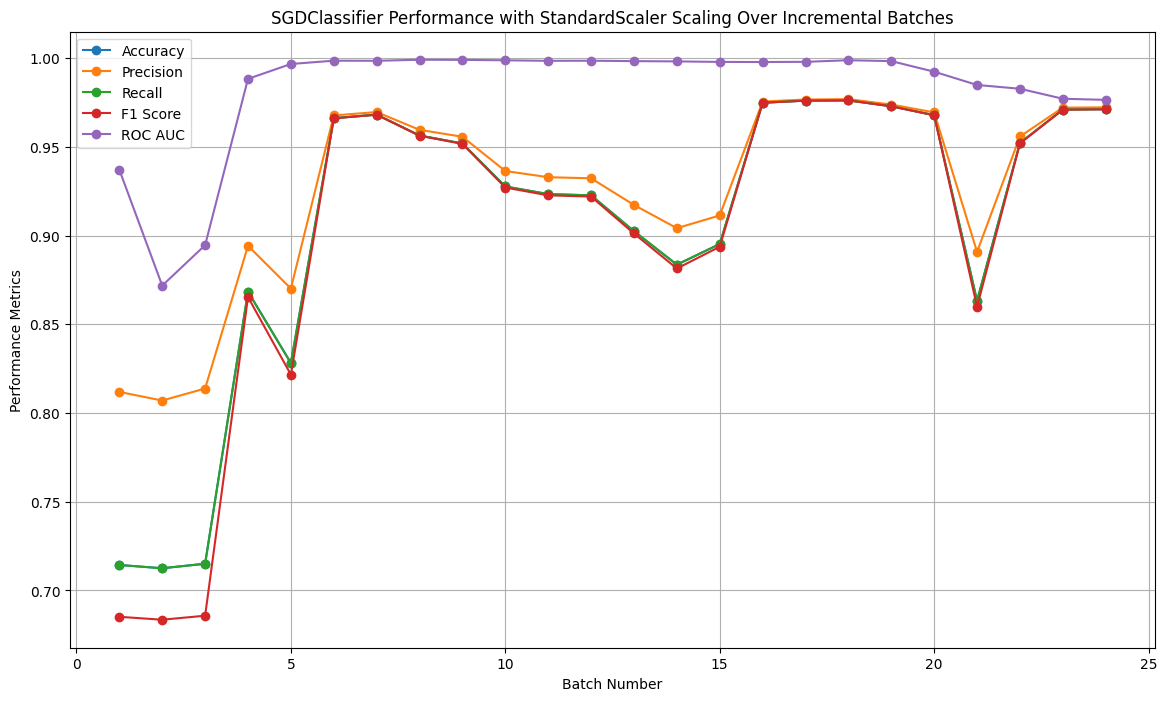

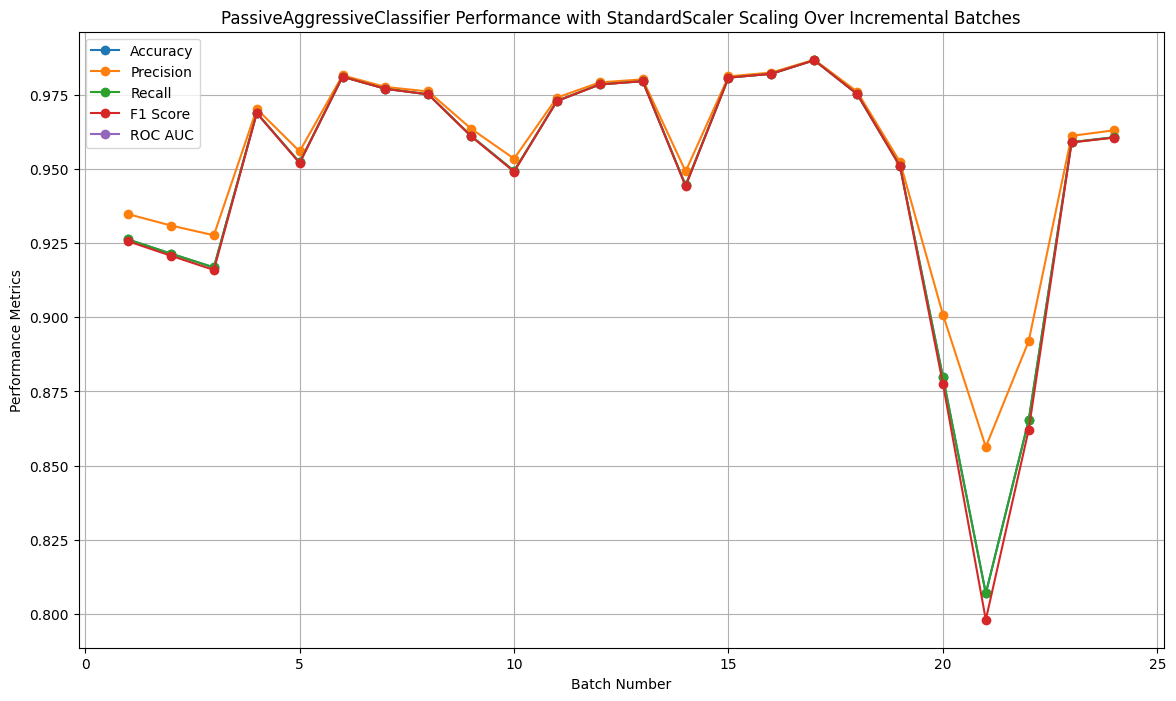

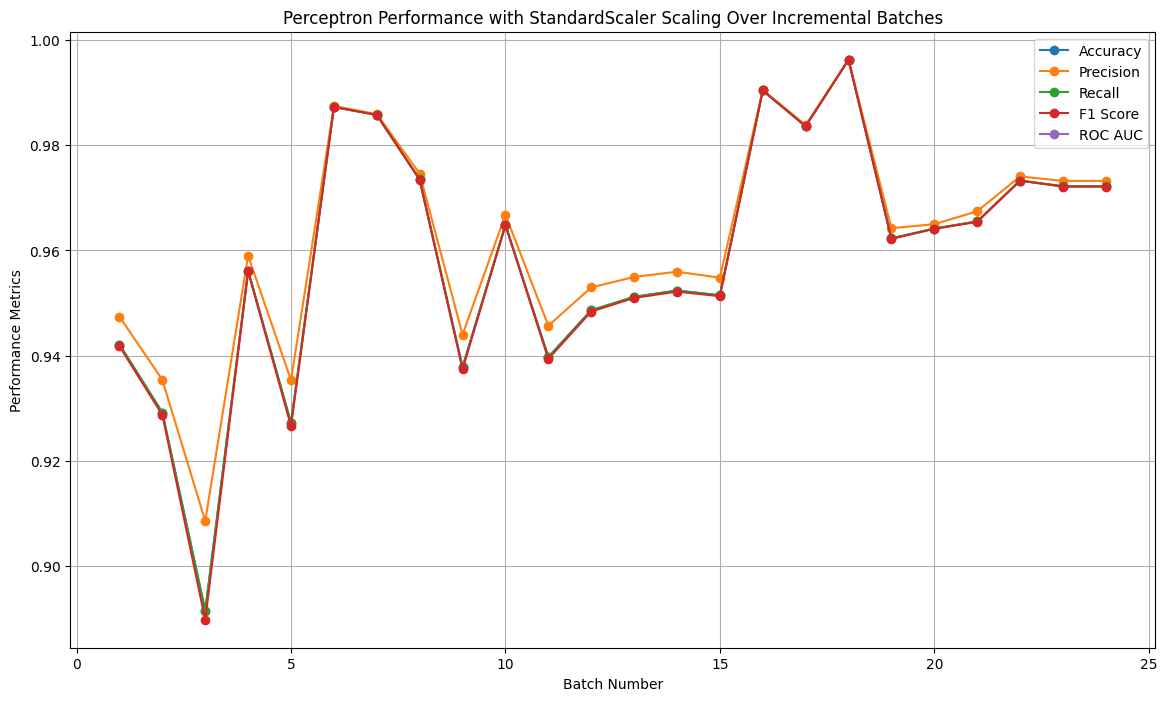

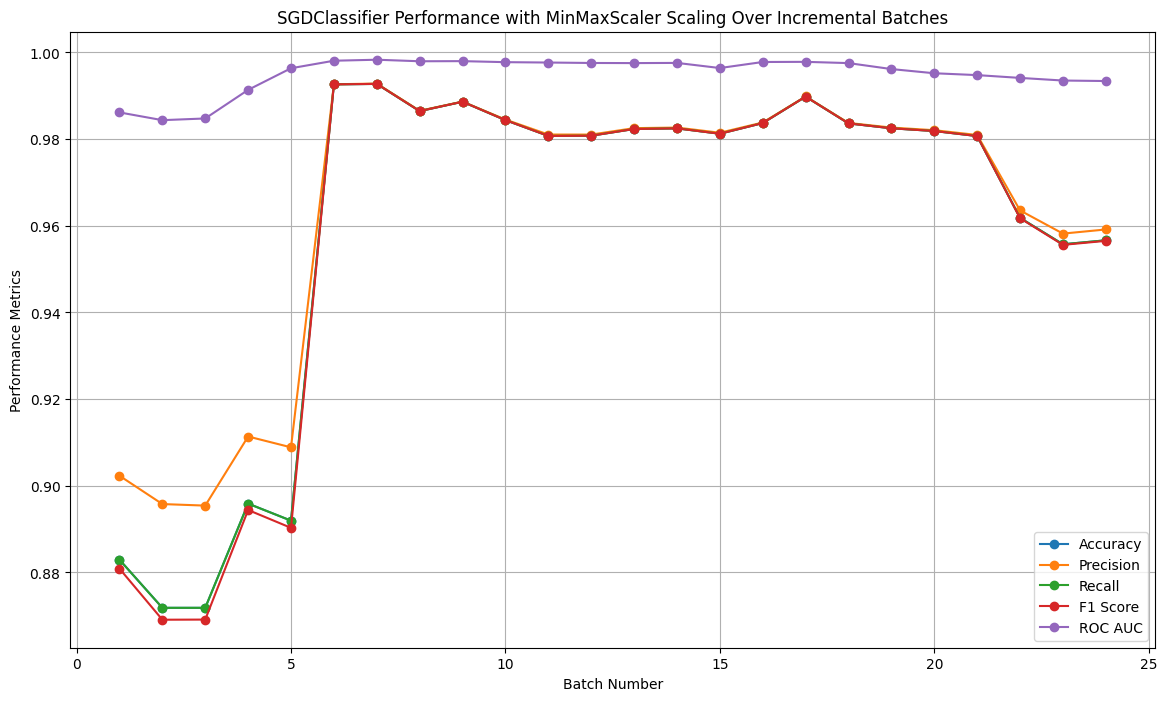

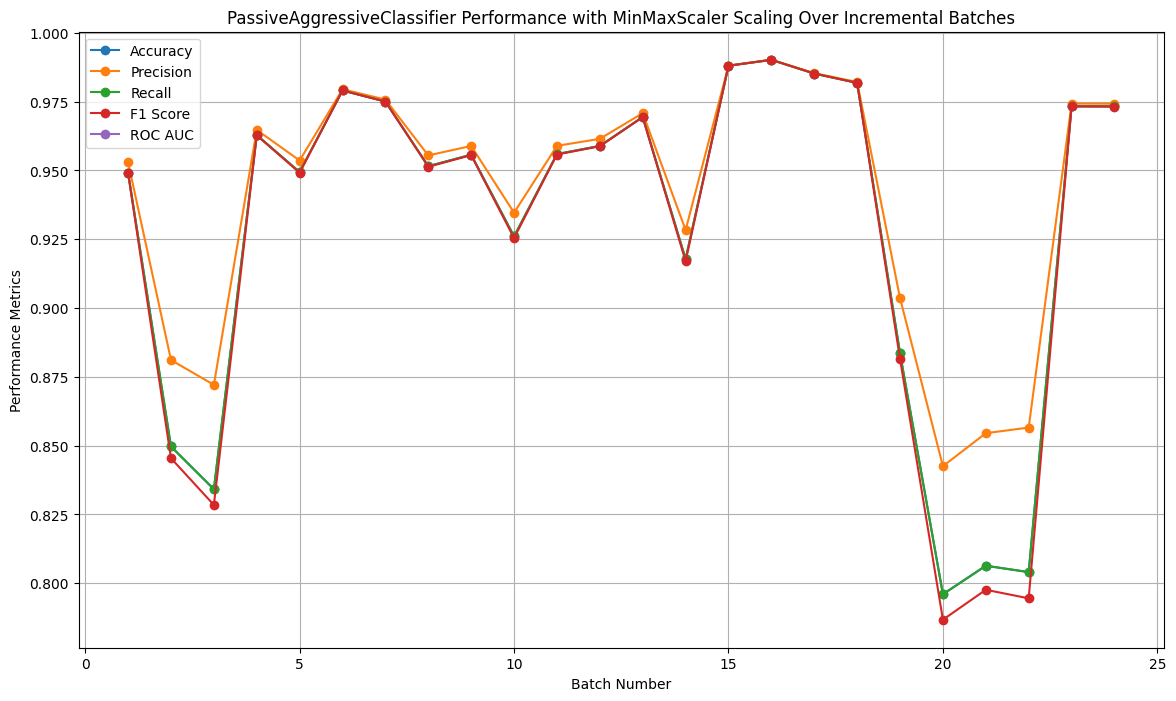

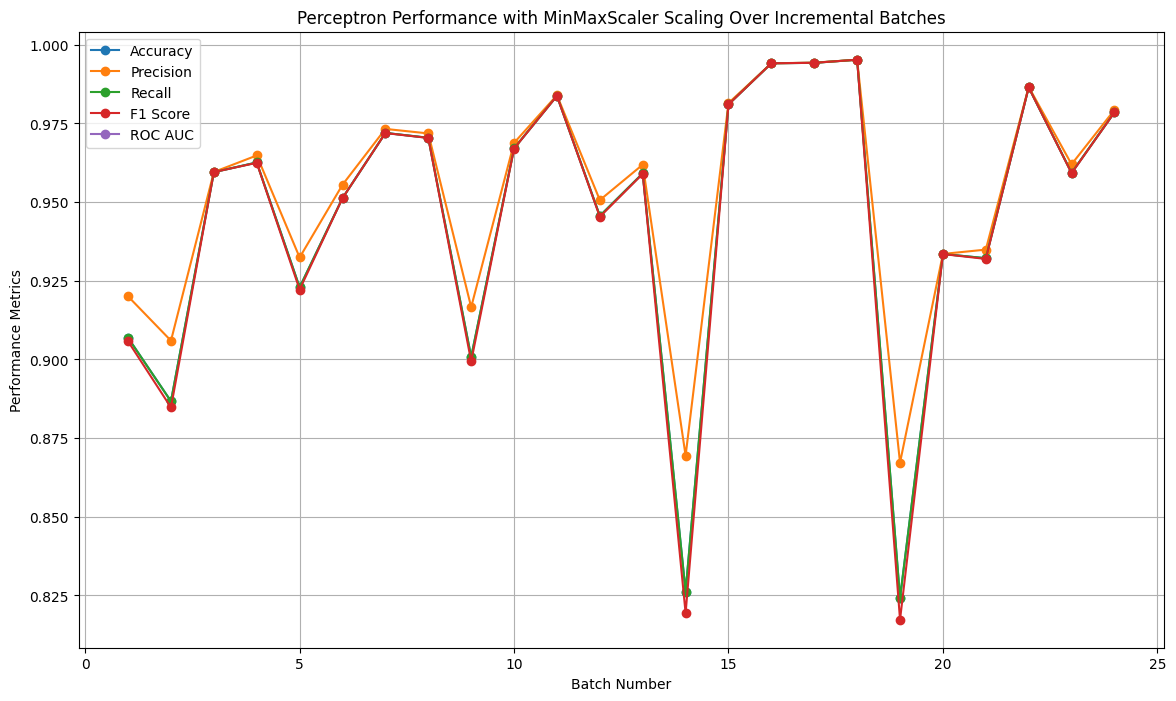

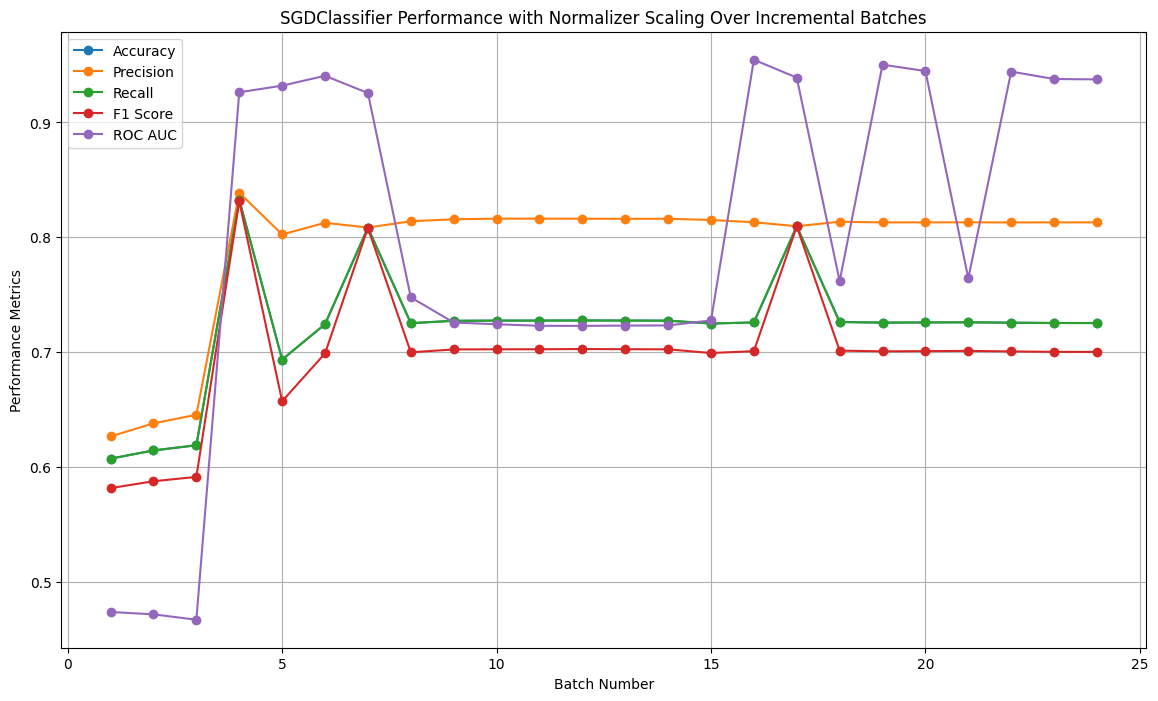

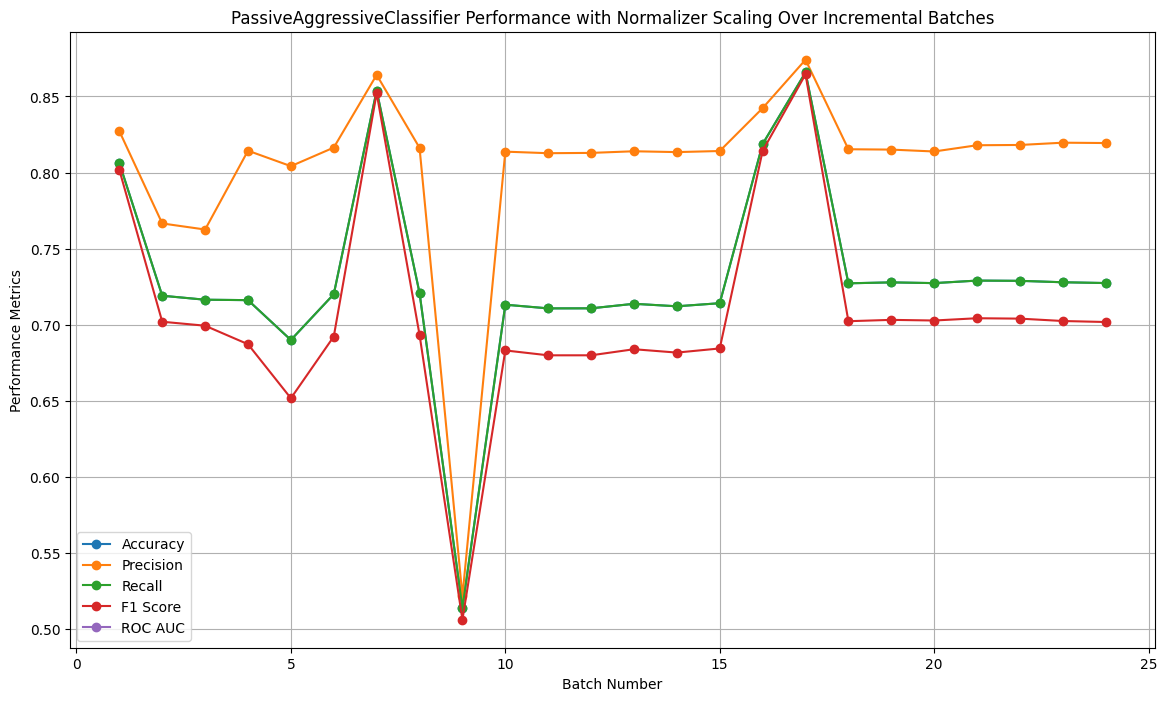

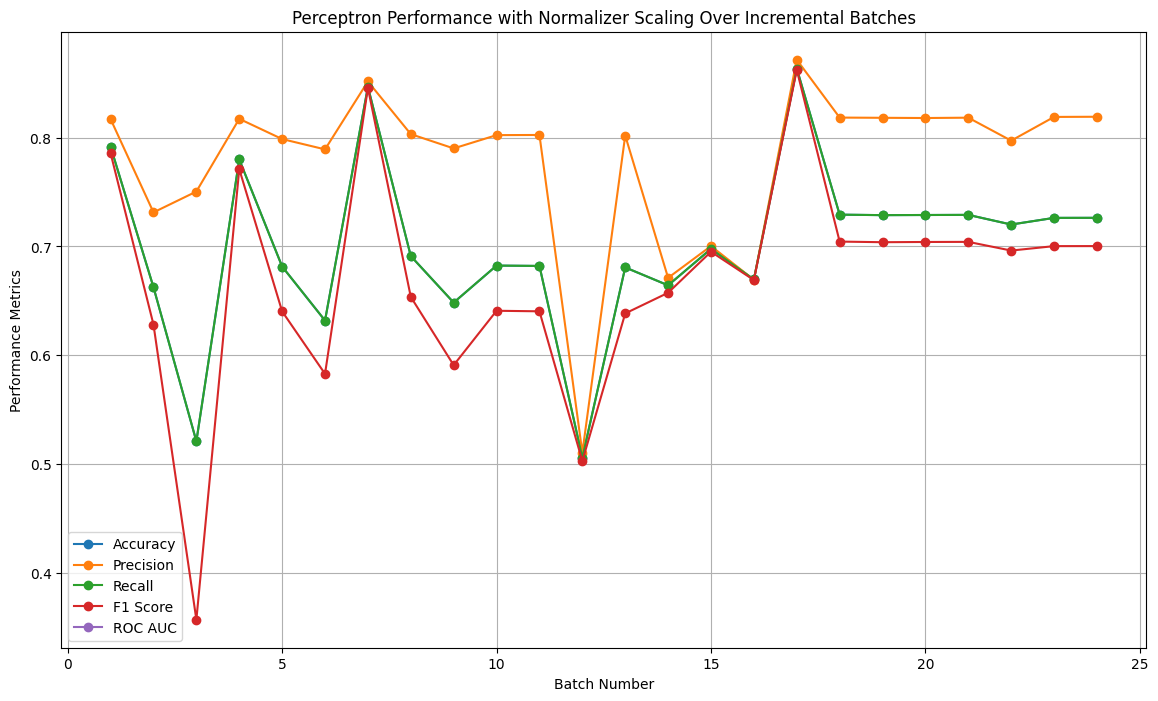

In [ ]:
# Plot all metrics after all scalers and models have been processed
for scaler_name, model_metrics in metrics_storage.items():
    for model_name, metrics in model_metrics.items():
        plot_metrics(metrics, model_name, scaler_name)

## Training Without Metadata, Correlated Features, and applying Log Transformation

In [ ]:
# List of features with null correlations to remove
features_to_remove = ['bwd_psh_flags', 'fwd_urg_flags', 'bwd_urg_flags',
                      'fwd_avg_bytes_bulk', 'fwd_avg_packets_bulk',
                      'fwd_avg_bulk_rate', 'bwd_avg_bytes_bulk',
                      'bwd_avg_packets_bulk', 'bwd_avg_bulk_rate']

clean_train_df = train_df.drop(columns=features_to_remove)
clean_test_df = test_df.drop(columns=features_to_remove)
# Remove the specified features
clean_data = data.drop(columns=features_to_remove)

# Verify the features have been removed
clean_train_df.head()

protocol  flow_duration  total_fwd_packets  total_backward_packets  \
0         6              2                  3                       0   
1        17          20754                  2                       2   
2         6             70                  2                       2   
3         6              3                  2                       0   
4         6              1                  2                       0   

   total_length_of_fwd_packets  total_length_of_bwd_packets  \
0                       1125.0                          0.0   
1                         56.0                        184.0   
2                         12.0                         12.0   
3                          0.0                          0.0   
4                         12.0                          0.0   

   fwd_packet_length_max  fwd_packet_length_min  fwd_packet_length_mean  \
0                 1094.0                    0.0                   375.0   
1                   28.0                   28.0                    28.0   
2                    6.0                    6.0                     6.0   
3                    0.0                    0.0                     0.0   
4                    6.0                    6.0                     6.0   

   fwd_packet_length_std  ...  min_seg_size_forward  active_mean  active_std  \
0             622.865173  ...                    32          0.0         0.0   
1               0.000000  ...                    32          0.0         0.0   
2               0.000000  ...                    20          0.0         0.0   
3               0.000000  ...                    32          0.0         0.0   
4               0.000000  ...                    20          0.0         0.0   

   active_max  active_min  idle_mean  idle_std  idle_max  idle_min  \
0         0.0         0.0        0.0       0.0       0.0       0.0   
1         0.0         0.0        0.0       0.0       0.0       0.0   
2         0.0         0.0        0.0       0.0       0.0       0.0   
3         0.0         0.0        0.0       0.0       0.0       0.0   
4         0.0         0.0        0.0       0.0       0.0       0.0   

   label_encoded  
0              0  
1              0  
2              1  
3              0  
4              1  

[5 rows x 69 columns]

In [ ]:
clean_train_df.head()

protocol  flow_duration  total_fwd_packets  total_backward_packets  \
0         6              2                  3                       0   
1        17          20754                  2                       2   
2         6             70                  2                       2   
3         6              3                  2                       0   
4         6              1                  2                       0   

   total_length_of_fwd_packets  total_length_of_bwd_packets  \
0                       1125.0                          0.0   
1                         56.0                        184.0   
2                         12.0                         12.0   
3                          0.0                          0.0   
4                         12.0                          0.0   

   fwd_packet_length_max  fwd_packet_length_min  fwd_packet_length_mean  \
0                 1094.0                    0.0                   375.0   
1                   28.0                   28.0                    28.0   
2                    6.0                    6.0                     6.0   
3                    0.0                    0.0                     0.0   
4                    6.0                    6.0                     6.0   

   fwd_packet_length_std  ...  min_seg_size_forward  active_mean  active_std  \
0             622.865173  ...                    32          0.0         0.0   
1               0.000000  ...                    32          0.0         0.0   
2               0.000000  ...                    20          0.0         0.0   
3               0.000000  ...                    32          0.0         0.0   
4               0.000000  ...                    20          0.0         0.0   

   active_max  active_min  idle_mean  idle_std  idle_max  idle_min  \
0         0.0         0.0        0.0       0.0       0.0       0.0   
1         0.0         0.0        0.0       0.0       0.0       0.0   
2         0.0         0.0        0.0       0.0       0.0       0.0   
3         0.0         0.0        0.0       0.0       0.0       0.0   
4         0.0         0.0        0.0       0.0       0.0       0.0   

   label_encoded  
0              0  
1              0  
2              1  
3              0  
4              1  

[5 rows x 69 columns]

In [ ]:
def apply_transformations(df, target_column='label_encoded'):
    # Apply transformations to numerical features only
    for column in df.columns:
        if df[column].dtype in [np.float64, np.int64] and column != target_column:
            df[column] = np.log1p(df[column])  # Example transformation
    return df

In [ ]:
X_train = clean_train_df.drop('label_encoded', axis=1)
y_train = clean_train_df['label_encoded']
X_test = clean_test_df.drop('label_encoded', axis=1)
y_test = clean_test_df['label_encoded']

In [ ]:
# Apply transformations if necessary
X_train_transform = apply_transformations(X_train)
X_test_transform = apply_transformations(X_test)

# Drop rows with missing values in X and adjust y accordingly
X_train = X_train_transform.dropna()
y_train = y_train[X_train.index]  # Adjust y_train to match the new indices of X_train_transform

X_test = X_test_transform.dropna()
y_test = y_test[X_test.index]     # Adjust y_test to match the new indices of X_test_transform


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
X_train.head()

protocol  flow_duration  total_fwd_packets  total_backward_packets  \
0         6              2                  3                       0   
1        17          20754                  2                       2   
2         6             70                  2                       2   
3         6              3                  2                       0   
4         6              1                  2                       0   

   total_length_of_fwd_packets  total_length_of_bwd_packets  \
0                       1125.0                          0.0   
1                         56.0                        184.0   
2                         12.0                         12.0   
3                          0.0                          0.0   
4                         12.0                          0.0   

   fwd_packet_length_max  fwd_packet_length_min  fwd_packet_length_mean  \
0                 1094.0                    0.0                   375.0   
1                   28.0                   28.0                    28.0   
2                    6.0                    6.0                     6.0   
3                    0.0                    0.0                     0.0   
4                    6.0                    6.0                     6.0   

   fwd_packet_length_std  ...  act_data_pkt_fwd  min_seg_size_forward  \
0             622.865173  ...                 1                    32   
1               0.000000  ...                 1                    32   
2               0.000000  ...                 1                    20   
3               0.000000  ...                 0                    32   
4               0.000000  ...                 1                    20   

   active_mean  active_std  active_max  active_min  idle_mean  idle_std  \
0          0.0         0.0         0.0         0.0        0.0       0.0   
1          0.0         0.0         0.0         0.0        0.0       0.0   
2          0.0         0.0         0.0         0.0        0.0       0.0   
3          0.0         0.0         0.0         0.0        0.0       0.0   
4          0.0         0.0         0.0         0.0        0.0       0.0   

   idle_max  idle_min  
0       0.0       0.0  
1       0.0       0.0  
2       0.0       0.0  
3       0.0       0.0  
4       0.0       0.0  

[5 rows x 68 columns]

In [ ]:

sgd_model = SGDClassifier(loss='log_loss', random_state=42, **sgd_params)
pa_model = PassiveAggressiveClassifier(random_state=42, max_iter=1000, tol=1e-3)
perceptron_model = Perceptron(max_iter=1000, tol=1e-3)

# Split the data into initial and incremental parts
initial_batch_size = int(0.2 * len(X_train))
X_initial, y_initial = X_train[:initial_batch_size], y_train[:initial_batch_size]
# Check shapes before training
print("Initial training data shape:", X_initial.shape)
print("Test data shape:", X_test.shape)

Initial training data shape: (28916, 68)
Test data shape: (62033, 68)


In [ ]:
train_df.head()

protocol  flow_duration  total_fwd_packets  total_backward_packets  \
0         6              2                  3                       0   
1        17          20754                  2                       2   
2         6             70                  2                       2   
3         6              3                  2                       0   
4         6              1                  2                       0   

   total_length_of_fwd_packets  total_length_of_bwd_packets  \
0                       1125.0                          0.0   
1                         56.0                        184.0   
2                         12.0                         12.0   
3                          0.0                          0.0   
4                         12.0                          0.0   

   fwd_packet_length_max  fwd_packet_length_min  fwd_packet_length_mean  \
0                 1094.0                    0.0                   375.0   
1                   28.0                   28.0                    28.0   
2                    6.0                    6.0                     6.0   
3                    0.0                    0.0                     0.0   
4                    6.0                    6.0                     6.0   

   fwd_packet_length_std  ...  min_seg_size_forward  active_mean  active_std  \
0             622.865173  ...                    32          0.0         0.0   
1               0.000000  ...                    32          0.0         0.0   
2               0.000000  ...                    20          0.0         0.0   
3               0.000000  ...                    32          0.0         0.0   
4               0.000000  ...                    20          0.0         0.0   

   active_max  active_min  idle_mean  idle_std  idle_max  idle_min  \
0         0.0         0.0        0.0       0.0       0.0       0.0   
1         0.0         0.0        0.0       0.0       0.0       0.0   
2         0.0         0.0        0.0       0.0       0.0       0.0   
3         0.0         0.0        0.0       0.0       0.0       0.0   
4         0.0         0.0        0.0       0.0       0.0       0.0   

   label_encoded  
0              0  
1              0  
2              1  
3              0  
4              1  

[5 rows x 78 columns]

In [ ]:

X_train.head(5).to_csv('first_5_X_train.csv', index=False)


In [ ]:
import pickle

print("Without Metadata + Correlated Feature and Applying Log transformation")

# Dictionary to store metrics data for each scaler and model combination
metrics_storage = {}

# Function to save an object to a .pkl file
def save_to_pickle(obj, filename):
    with open(filename, 'wb') as file:
        pickle.dump(obj, file)
    print(f"Saved {filename}")

# Function to load an object from a .pkl file
def load_from_pickle(filename):
    with open(filename, 'rb') as file:
        return pickle.load(file)

# Loop through different scalers and models
for scaler_name, scaler in scalers.items():
    print(f"\nUsing {scaler_name}:")

    # Scale data
    X_train_scaled, X_test_scaled, X_initial_scaled = scale_data(scaler, X_train, X_test, X_initial)

    # Save the scaler
    save_to_pickle(scaler, f"{scaler_name}_scaler.pkl")

    # Dictionary to store metrics for each model for the current scaler
    model_metrics = {}

    # Incremental training and evaluation for SGDClassifier
    print("\nTraining SGDClassifier:")
    sgd_metrics = incremental_training(sgd_model, X_train_scaled, y_train, X_test_scaled, y_test, initial_batch_size, batch_size)
    model_metrics['SGDClassifier'] = sgd_metrics
    # Save the model after training
    save_to_pickle(sgd_model, f"{scaler_name}_SGDClassifier_model.pkl")

    # Incremental training and evaluation for PassiveAggressiveClassifier
    print("\nTraining PassiveAggressiveClassifier:")
    pa_metrics = incremental_training(pa_model, X_train_scaled, y_train, X_test_scaled, y_test, initial_batch_size, batch_size)
    model_metrics['PassiveAggressiveClassifier'] = pa_metrics
    # Save the model after training
    save_to_pickle(pa_model, f"{scaler_name}_PassiveAggressiveClassifier_model.pkl")

    # Incremental training and evaluation for Perceptron
    print("\nTraining Perceptron:")
    perceptron_metrics = incremental_training(perceptron_model, X_train_scaled, y_train, X_test_scaled, y_test, initial_batch_size, batch_size)
    model_metrics['Perceptron'] = perceptron_metrics
    # Save the model after training
    save_to_pickle(perceptron_model, f"{scaler_name}_Perceptron_model.pkl")

    # Store metrics for the current scaler
    metrics_storage[scaler_name] = model_metrics

# Save the entire metrics storage to a file
save_to_pickle(metrics_storage, "metrics_storage.pkl")


Without Metadata + Correlated Feature and Applying Log transformation

Using StandardScaler:
Saved StandardScaler_scaler.pkl

Training SGDClassifier:

Initial Model Evaluation:
Accuracy: 0.7144745538664904
Precision: 0.8126375733628535
Recall: 0.7144745538664904
F1 Score: 0.6851707320460514
ROC AUC: 0.860844328135639

Metrics after batch 1:
Accuracy: 0.7143617107023681
Precision: 0.8118750706232211
Recall: 0.7143617107023681
F1 Score: 0.6851606524627727
ROC AUC: 0.9370497679348466

Metrics after batch 2:
Accuracy: 0.7125078587203585
Precision: 0.8070142461332104
Recall: 0.7125078587203585
F1 Score: 0.6835160856862819
ROC AUC: 0.8717615417960416

Metrics after batch 3:
Accuracy: 0.715071010591137
Precision: 0.8137924901074411
Recall: 0.715071010591137
F1 Score: 0.6857833920306126
ROC AUC: 0.8945825154502713

Metrics after batch 4:
Accuracy: 0.8683603888253026
Precision: 0.8942127304750932
Recall: 0.8683603888253026
F1 Score: 0.865331432295642
ROC AUC: 0.9882763004483862

Metrics after b

### Evaluation Matrix for Without Metadata, and Correlated Features and After Log Transformation

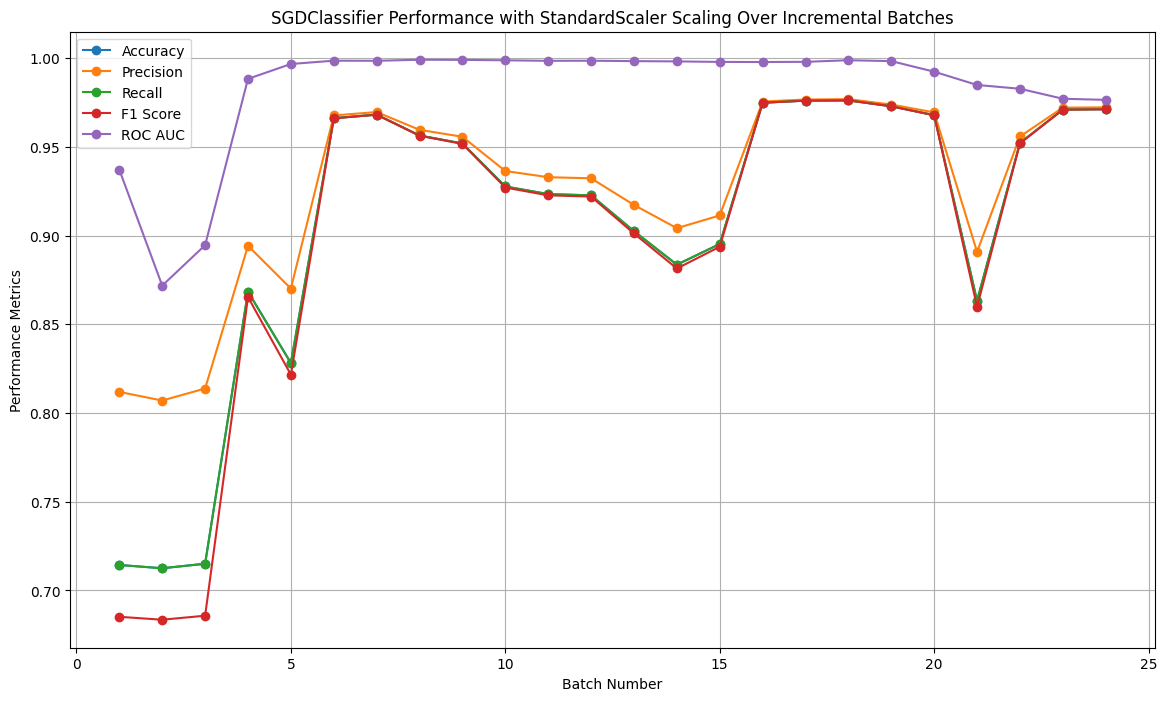

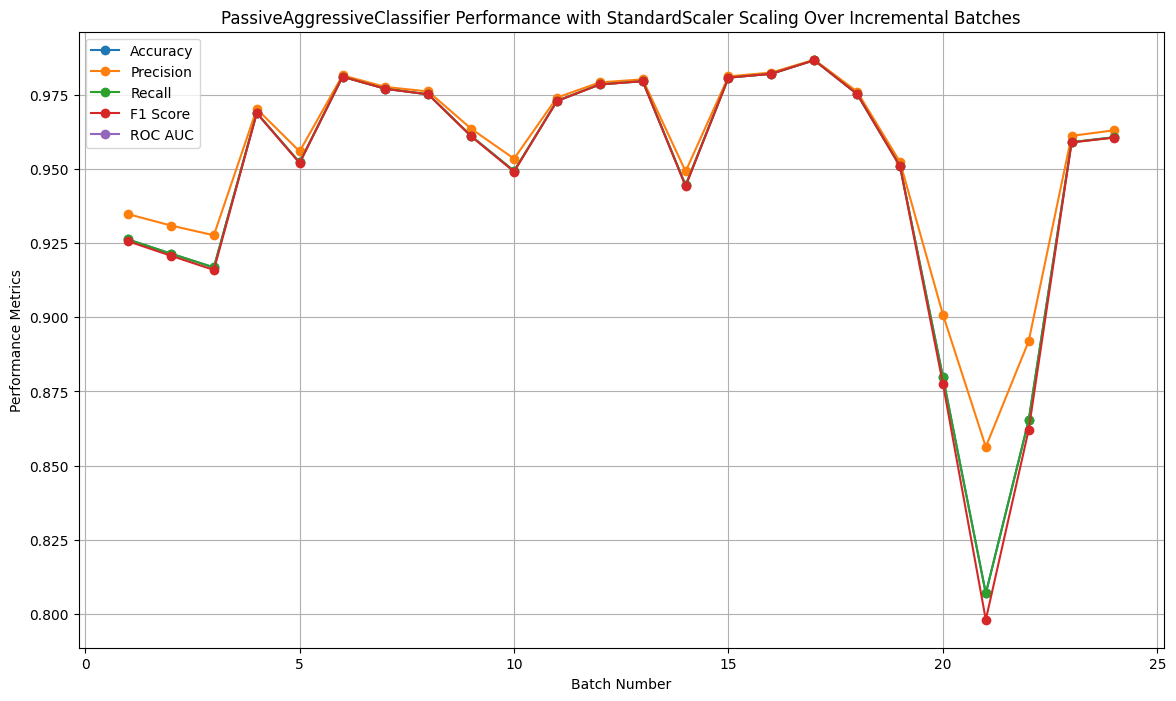

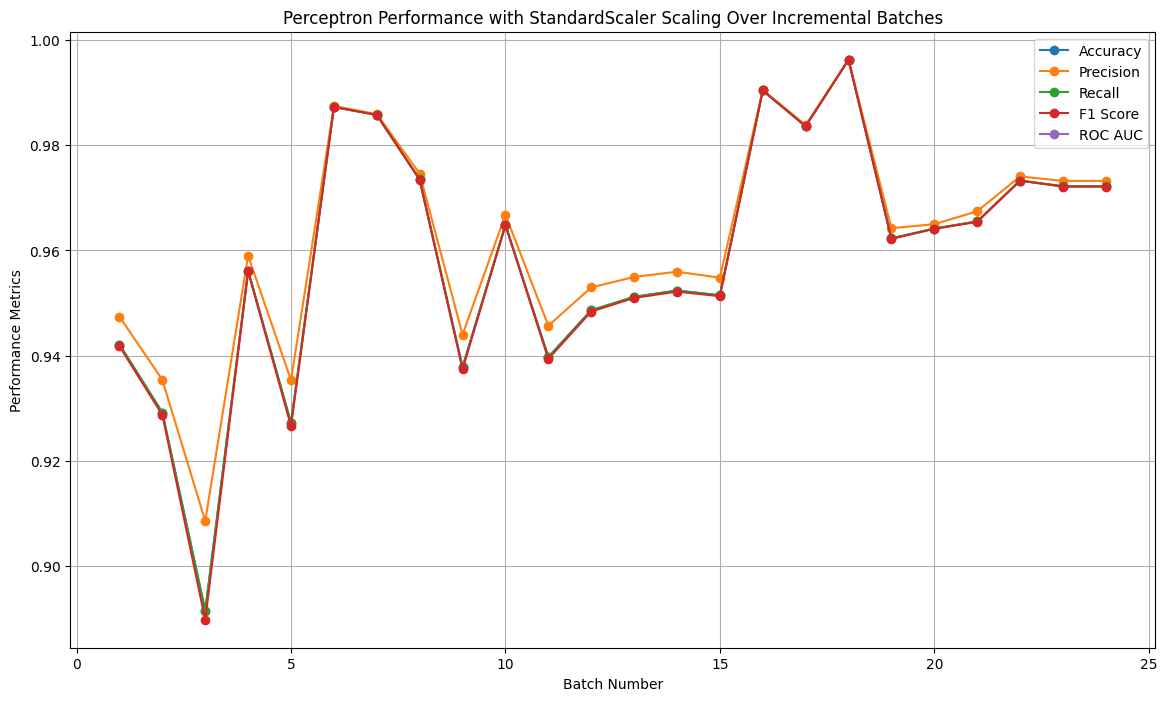

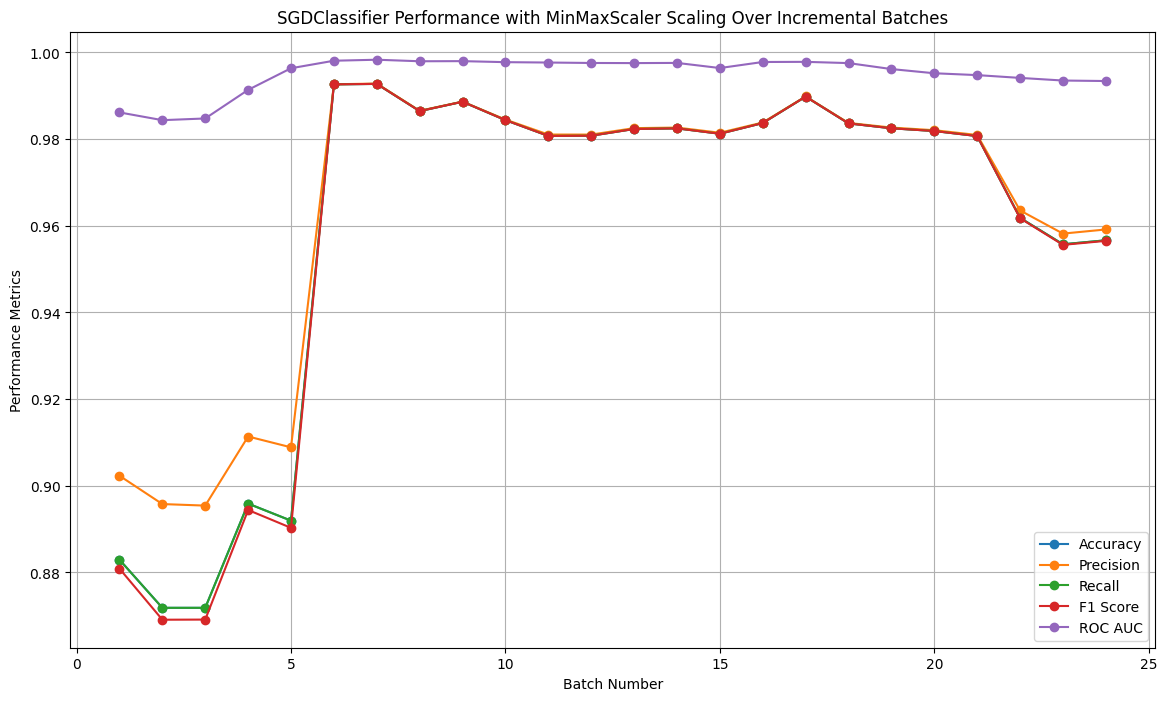

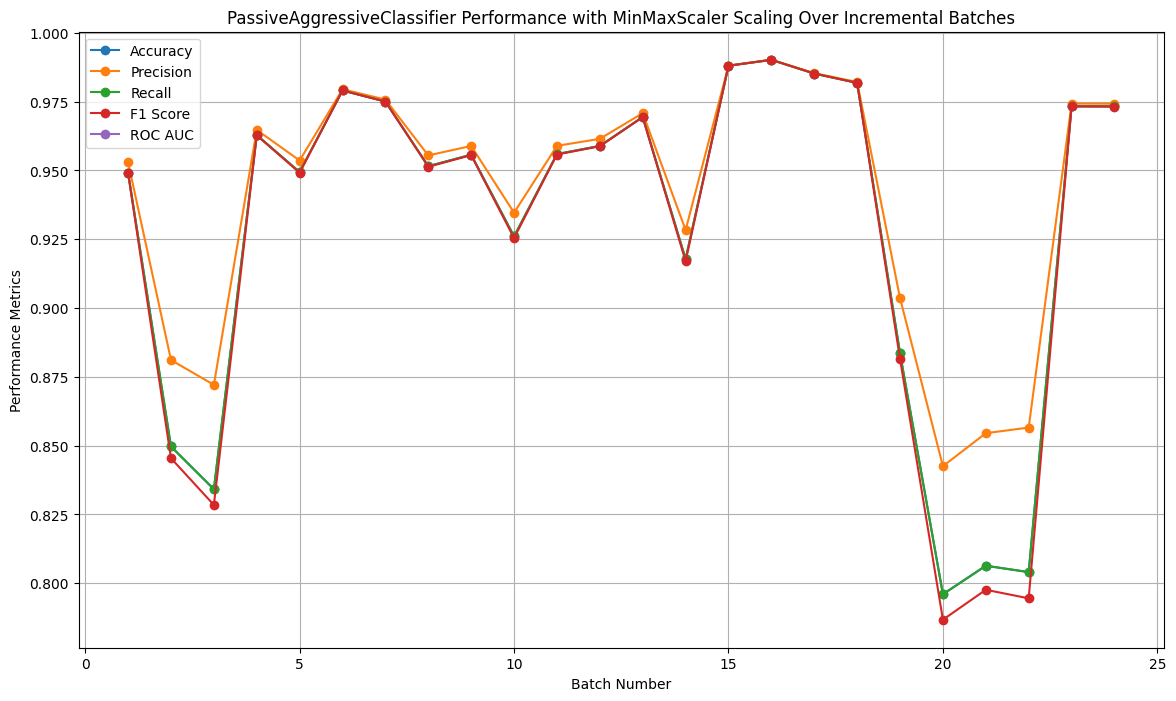

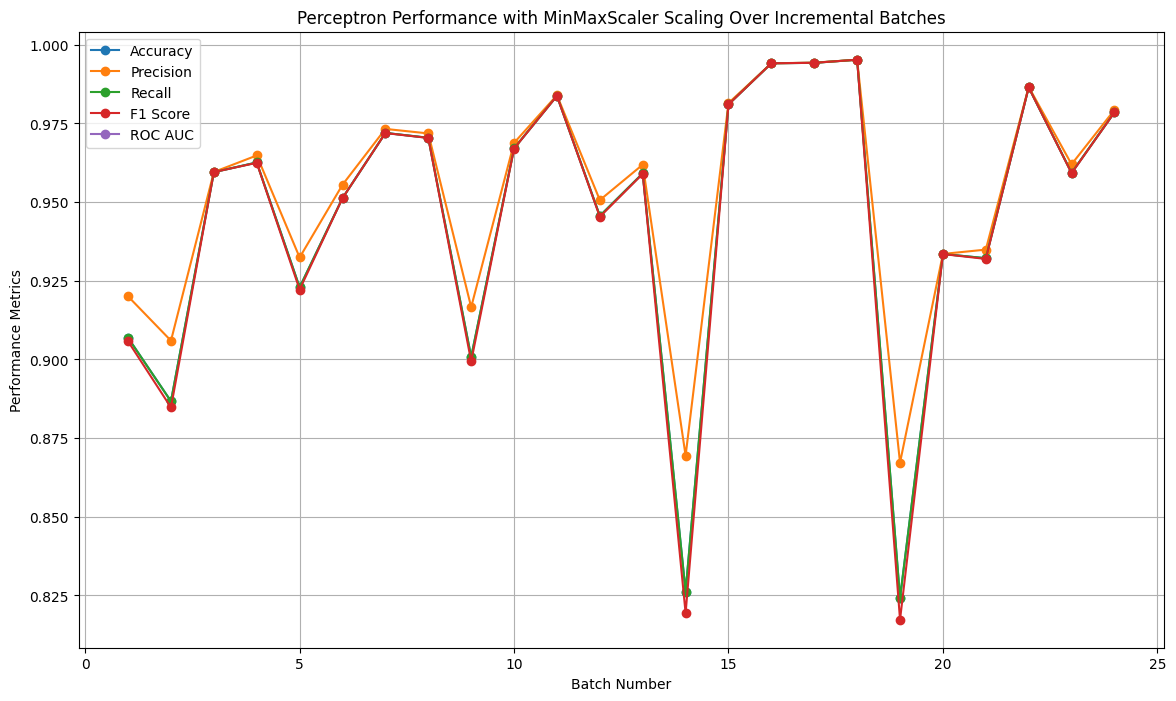

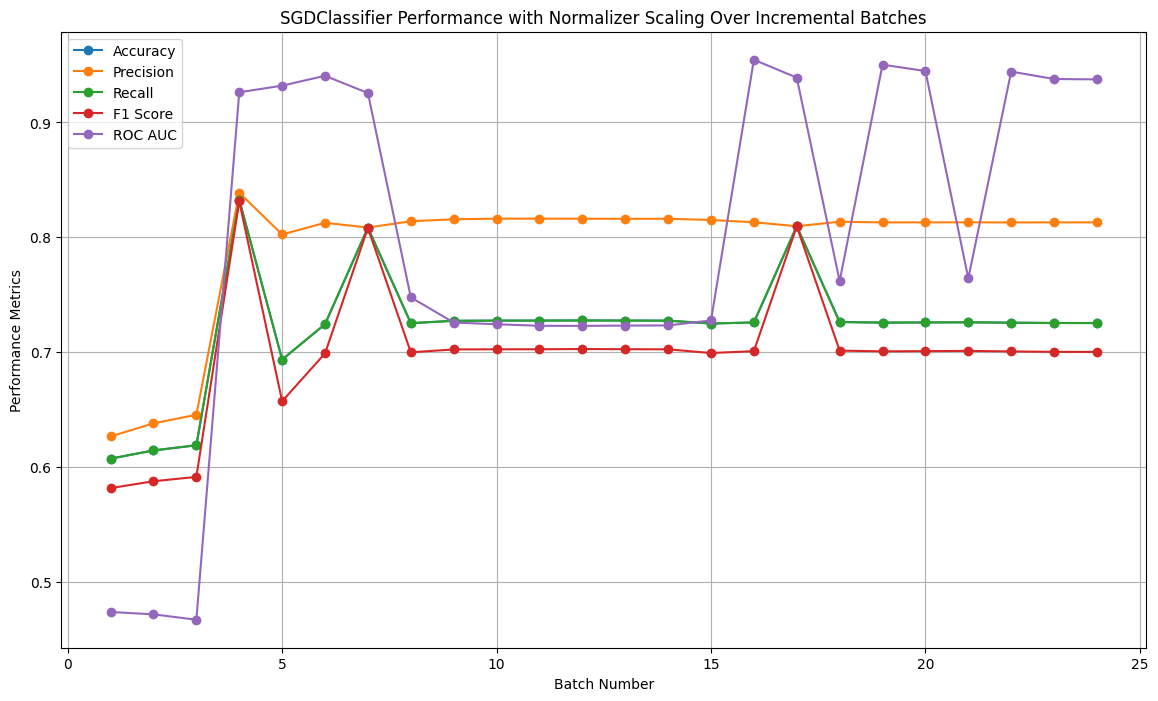

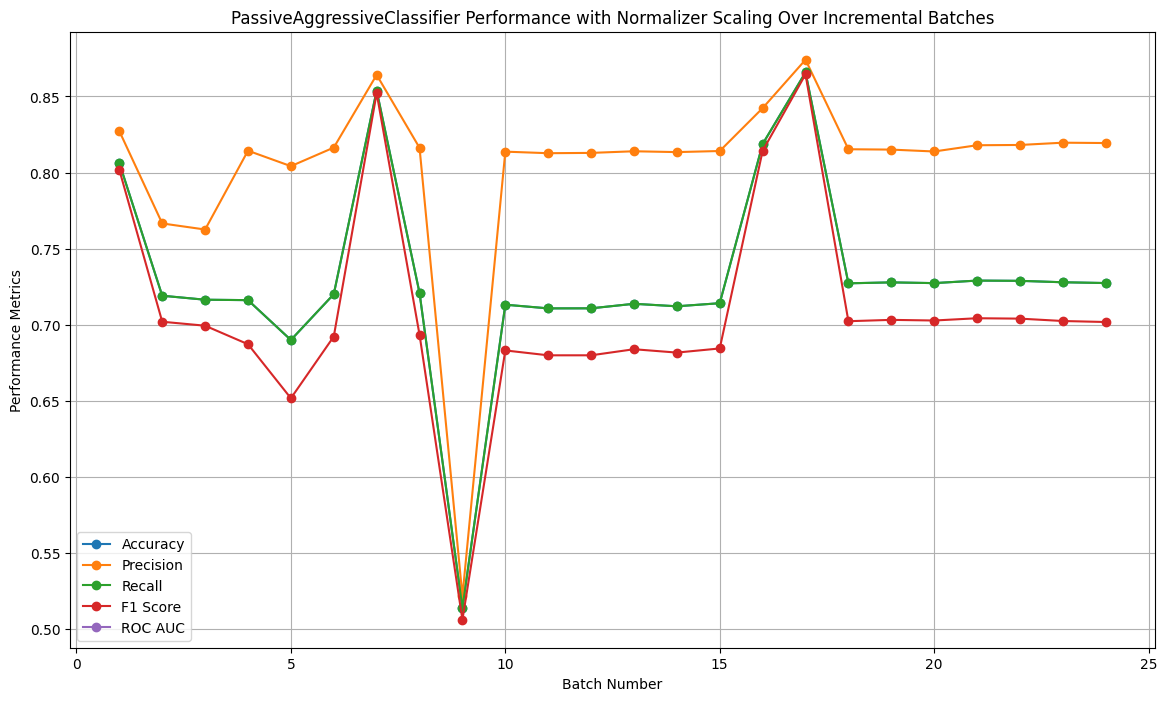

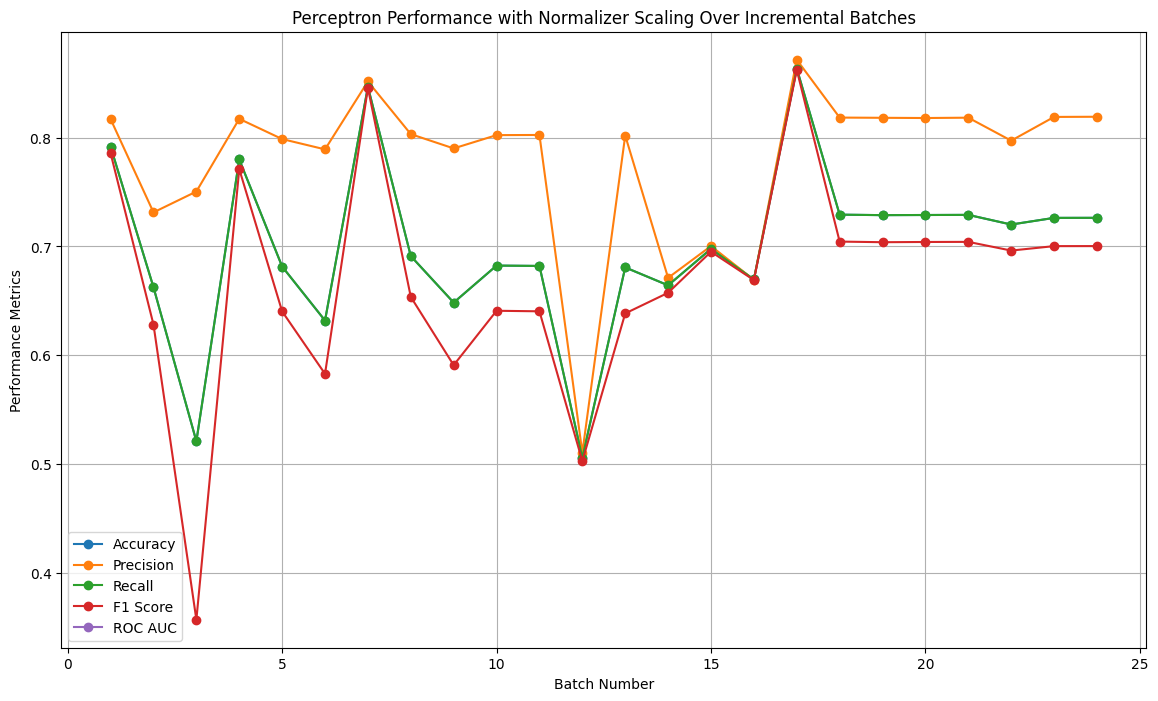

In [ ]:
# Plot all metrics after all scalers and models have been processed
for scaler_name, model_metrics in metrics_storage.items():
    for model_name, metrics in model_metrics.items():
        plot_metrics(metrics, model_name, scaler_name)

In [ ]:
# Dictionary to store the average performance scores for each combination
average_performance_scores = {}

# Calculate average metrics for each combination and determine the best
for scaler_name, model_metrics in metrics_storage.items():
    for model_name, metrics in model_metrics.items():
        # Convert 'None' to 'NaN' for averaging
        accuracy_values = np.array([m[0] if m[0] is not None else np.nan for m in metrics])
        precision_values = np.array([m[1] if m[1] is not None else np.nan for m in metrics])
        recall_values = np.array([m[2] if m[2] is not None else np.nan for m in metrics])
        f1_values = np.array([m[3] if m[3] is not None else np.nan for m in metrics])

        # Calculate the average for each metric
        avg_accuracy = np.nanmean(accuracy_values)
        avg_precision = np.nanmean(precision_values)
        avg_recall = np.nanmean(recall_values)
        avg_f1 = np.nanmean(f1_values)

        # Calculate standard deviation for consistency
        std_accuracy = np.nanstd(accuracy_values)
        std_precision = np.nanstd(precision_values)
        std_recall = np.nanstd(recall_values)
        std_f1 = np.nanstd(f1_values)

        # Calculate the average ROC AUC if available
        if metrics.shape[1] > 4:
            roc_auc_values = np.array([m[4] if m[4] is not None else np.nan for m in metrics])
            avg_roc_auc = np.nanmean(roc_auc_values)
            std_roc_auc = np.nanstd(roc_auc_values)
        else:
            avg_roc_auc = np.nan  # Use NaN for unavailable ROC AUC
            std_roc_auc = np.nan

        # Normalize metrics for composite scoring
        performance_score = np.nanmean([avg_accuracy, avg_precision, avg_recall, avg_f1, avg_roc_auc])
        consistency_score = np.nanmean([std_accuracy, std_precision, std_recall, std_f1, std_roc_auc])

        # Composite score that combines high performance and low variability (1/consistency_score)
        composite_score = performance_score / (1 + consistency_score)  # Adding 1 to prevent division by zero

        # Store the average scores, standard deviations, and composite score
        average_performance_scores[(scaler_name, model_name)] = {
            'Average Accuracy': avg_accuracy,
            'Average Precision': avg_precision,
            'Average Recall': avg_recall,
            'Average F1 Score': avg_f1,
            'Average ROC AUC': avg_roc_auc,
            'Std Accuracy': std_accuracy,
            'Std Precision': std_precision,
            'Std Recall': std_recall,
            'Std F1 Score': std_f1,
            'Std ROC AUC': std_roc_auc,
            'Composite Score': composite_score
        }

# Find the best combination based on the composite score
best_combination = max(average_performance_scores.items(), key=lambda x: x[1]['Composite Score'])

# Display the best combination
print(f"\nBest Model and Scaling Combination: {best_combination[0]}")
print(f"Performance Metrics: {best_combination[1]}")


Best Model and Scaling Combination: ('StandardScaler', 'Perceptron')
Performance Metrics: {'Average Accuracy': 0.9591178619981838, 'Average Precision': 0.9623683356789599, 'Average Recall': 0.9591178619981838, 'Average F1 Score': 0.9589002703844519, 'Average ROC AUC': nan, 'Std Accuracy': 0.02345491675254513, 'Std Precision': 0.019997572866295395, 'Std Recall': 0.02345491675254513, 'Std F1 Score': 0.023754666692344953, 'Std ROC AUC': nan, 'Composite Score': 0.938602177711579}


<ipython-input-184-bb4a3b235b6f>:28: RuntimeWarning: Mean of empty slice
  avg_roc_auc = np.nanmean(roc_auc_values)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
